# USP PhD Thesis - Copulas and Bayesian Networks

## Summary

### [0. Initialization](#0_initialization)
#### [0.1. Dataset Selection](#0_1_dataset_selection)
### [1. DATASETs](#1_DATASETs)
### [2. Normalization](#2_normalization)
### [3. Bayesian Network Copula](#3_bn_copula)
### [4. Thesis Figures](#4_thesis_figures)

<a id='0_initialization'></a>
<a href='#3_bn_copula'></a>

## 0. Initialization

### Imports and Global Variables

In [1]:
import os
import os.path 
import numpy as np
from scipy import stats as stt
from scipy.stats import rankdata, expon
from scipy.special import comb
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn import mixture
from sklearn.mixture import GaussianMixture as GM
import pickle as pk
import copy
from copy import deepcopy
import networkx as nx
from pgmpy.estimators import PC, HillClimbSearch, ExhaustiveSearch
from pgmpy.estimators import K2Score as K2, BicScore as BIC, BDeuScore as BDeu
from pgmpy.estimators.MLE import MaximumLikelihoodEstimator as MLE
from pgmpy.models import BayesianModel
np.random.seed(2011)

data = {}

### Parameters

In [2]:
data_dir = '/media/willian/Seagate Expansion Drive/GoogleDrive/USP_SCarlos/'\
            +'Doutorado/Tese/Documentos/Tese/data/'
data_analysis_dir = data_dir+'analysis/'
fig_dir = '/media/willian/Seagate Expansion Drive/GoogleDrive/USP_SCarlos/'\
            +'Doutorado/Tese/Documentos/Tese/figures/results/'

datasus_df_dir = '/media/willian/Seagate Expansion Drive/GoogleDrive/USP_SCarlos/Doutorado/Tese/Documentos/'\
                    +'Tese/figures/results/'
datasus_df_fname = 'DATASUS_df.pkl'
data_sus_fpath = datasus_df_dir+datasus_df_fname

tax_dir = '/media/willian/Seagate Expansion Drive/GoogleDrive/USP_SCarlos/Doutorado/'\
            +'Tese/Experimentos/Databases/Brasil/'
tax_fname = 'Brasil.pkl'
tax_full_cols = ['UF_str', 'Munic_code', 'Munic_str', 'Pop_nr', 'Altitude_val',
       'Area_val', 'Latitude_val', 'Longitude_val', 'ChuvaInv_val',
       'ChuvaVer_val', 'TempInv_val', 'TempVer_val', 'Rendimentos_val',
       'FPM_val', 'ReceitaTrib_val', 'QtdeDecl_nr', 'RendTrib_val',
       'RendTribExcl_val', 'RendIsentos_val', 'ContrPrevid_val', 'Depend_nr',
       'Instrucao_val', 'Medicas_val', 'LivroCaixa_val', 'PensaoAlim_val',
       'DescPadrao_val', 'BaseCalc_val', 'ImpDevido_val', 'ImpPago_val',
       'ImpPagar_val', 'ImpRest_val', 'BensDir_val', 'DivOnus_val',
       'DoacaoHer_val', 'Municipio_str', 'Agropec_nr', 'Agropec_val',
       'IndExtrativa_nr', 'IndExtrativa_val', 'IndTransform_nr',
       'IndTransform_val', 'Energia_nr', 'Energia_val', 'AguaEsgotoResiduo_nr',
       'AguaEsgotoResiduo_val', 'Construcao_nr', 'Construcao_val',
       'ComercioManut_nr', 'ComercioManut_val', 'TranspArmaz_nr',
       'TranspArmaz_val', 'AlojAlim_nr', 'AlojAlim_val', 'InformComunic_nr',
       'InformComunic_val', 'Financ_Seguro_nr', 'Financ_Seguro_val',
       'Imobiliaria_nr', 'Imobiliaria_val', 'ProfissCientifTecnicas_nr',
       'ProfissCientifTecnicas_val', 'Administr_nr', 'Administr_val',
       'AdmPublica_nr', 'AdmPublica_val', 'Educacao_nr', 'Educacao_val',
       'SaudeServSocial_nr', 'SaudeServSocial_val', 'CulturaLazerEsporte_nr',
       'CulturaLazerEsporte_val', 'OutrosServicos_nr', 'OutrosServicos_val',
       'ServDomestico_nr', 'ServDomestico_val', 'OrgInternac_nr',
       'OrgInternac_val']
tax_cols = ['UF_str', 'Munic_str', 'Pop_nr', 'Altitude_val', 'Area_val', 'Latitude_val', 'Longitude_val',\
            'Rendimentos_val', 'FPM_val', 'ReceitaTrib_val', 'QtdeDecl_nr', 'RendTrib_val']

toy_weights, toy_mu_delta = [0.35, 0.45, 0.2], 3.0
toy_correlation = {'indep':0.0, 'posdep':0.999, 'negdep':-0.999, 'rnddep':0.3}
# rnddep = 0.8*np.random.choice([-1,1])*np.random.rand()}
ToyDatasets = \
{'A11_2_Indep_Uni':{'N':1000,'d':2,'dep_type':'indep','modal_type':'unimodal','plot':'yes'},\
 'A12_2_Posdep_Uni':{'N':1000,'d':2,'dep_type':'posdep','modal_type':'unimodal','plot':'no'},\
 'A13_2_Negdep_Uni':{'N':1000,'d':2,'dep_type':'negdep','modal_type':'unimodal','plot':'no'},\
 'A14_2_Rnddep_Uni':{'N':1000,'d':2,'dep_type':'rnddep','modal_type':'unimodal','plot':'no'},\
 'A21_2_Indep_Tri':{'N':1000,'d':2,'dep_type':'indep','modal_type':'trimodal','plot':'no'},\
 'A22_2_Posdep_Tri':{'N':1000,'d':2,'dep_type':'posdep','modal_type':'trimodal','plot':'no'},\
 'A23_2_Negdep_Tri':{'N':1000,'d':2,'dep_type':'negdep','modal_type':'trimodal','plot':'no'},\
 'A24_2_Rnddep_Tri':{'N':1000,'d':2,'dep_type':'rnddep','modal_type':'trimodal','plot':'no'},\
 'B11_6_Indep_Uni':{'N':10000,'d':6,'dep_type':'indep','modal_type':'unimodal','plot':'no'},\
 'B12_6_Posdep_Uni':{'N':10000,'d':6,'dep_type':'posdep','modal_type':'unimodal','plot':'no'},\
 'B13_6_Negdep_Uni':{'N':10000,'d':6,'dep_type':'negdep','modal_type':'unimodal','plot':'no'},\
 'B14_6_Rnddep_Uni':{'N':10000,'d':6,'dep_type':'rnddep','modal_type':'unimodal','plot':'no'},\
 'B21_6_Indep_Tri':{'N':1000,'d':6,'dep_type':'indep','modal_type':'trimodal','plot':'no'},\
 'B22_6_Posdep_Tri':{'N':1000,'d':6,'dep_type':'posdep','modal_type':'trimodal','plot':'no'},\
 'B23_6_Negdep_Tri':{'N':1000,'d':6,'dep_type':'negdep','modal_type':'trimodal','plot':'no'},\
 'B24_6_Rnddep_Tri':{'N':1000,'d':6,'dep_type':'rnddep','modal_type':'trimodal','plot':'no'},\
 'C11_10_Indep_Uni':{'N':1000,'d':10,'dep_type':'indep','modal_type':'unimodal','plot':'no'},\
 'C12_10_Posdep_Uni':{'N':1000,'d':10,'dep_type':'posdep','modal_type':'unimodal','plot':'no'},\
 'C13_10_Negdep_Uni':{'N':1000,'d':10,'dep_type':'negdep','modal_type':'unimodal','plot':'no'},\
 'C14_10_Rnddep_Uni':{'N':1000,'d':10,'dep_type':'rnddep','modal_type':'unimodal','plot':'no'},\
 'C21_10_Indep_Tri':{'N':1000,'d':10,'dep_type':'indep','modal_type':'trimodal','plot':'no'},\
 'C22_10_Posdep_Tri':{'N':1000,'d':10,'dep_type':'posdep','modal_type':'trimodal','plot':'no'},\
 'C23_10_Negdep_Tri':{'N':1000,'d':10,'dep_type':'negdep','modal_type':'trimodal','plot':'no'},\
 'C24_10_Rnddep_Tri':{'N':1000,'d':10,'dep_type':'rnddep','modal_type':'trimodal','plot':'no'},\
}
data_params = {'A11_2_Indep_Uni':{'x1':{'dist':'Beta', 'params':[[4.9081, 4.3839]]},\
                                  'x2':{'dist':'Beta', 'params':[[3.4180, 2.9951]]}},\
               'A12_2_Posdep_Uni':{'x1':{'dist':'Beta', 'params':[[4.1335, 4.2661]]},\
                                   'x2':{'dist':'Beta', 'params':[[3.4625, 3.2525]]}},\
               'A13_2_Negdep_Uni':{'x1':{'dist':'Beta', 'params':[[3.9057, 4.5626]]},\
                                   'x2':{'dist':'Beta', 'params':[[3.3627, 3.8832]]}},\
               'A14_2_Rnddep_Uni':{'x1':{'dist':'Beta', 'params':[[3.6006, 3.4188]]},\
                                   'x2':{'dist':'Beta', 'params':[[3.9705, 4.1767]]}},\
               'A21_2_Indep_Tri':{'x1':{'dist':'Beta', 'params':[[2.2071, 2.6002]]},\
                                  'x2':{'dist':'Beta', 'params':[[3.4782, 4.0034]]}},\
               'A22_2_Posdep_Tri':{'x1':{'dist':'Beta', 'params':[[2.1631, 2.6039]]},\
                                   'x2':{'dist':'Beta', 'params':[[3.0938, 3.6746]]}},\
               'A23_2_Negdep_Tri':{'x1':{'dist':'Beta', 'params':[[3.2685, 2.3709]]},\
                                   'x2':{'dist':'Beta', 'params':[[3.2868, 3.4926]]}},\
               'A24_2_Rnddep_Tri':{'x1':{'dist':'Beta', 'params':[[2.3113, 2.5125]]},\
                                   'x2':{'dist':'Beta', 'params':[[2.9737, 3.5914]]}},\
               'B11_6_Indep_Uni':{'x1':{'dist':'Beta', 'params':[[0.0, 0.0]]},\
                                   'x2':{'dist':'Beta', 'params':[[0.0, 0.0]]},\
                                   'x3':{'dist':'Beta', 'params':[[0.0, 0.0]]},\
                                   'x4':{'dist':'Beta', 'params':[[0.0, 0.0]]},\
                                   'x5':{'dist':'Beta', 'params':[[0.0, 0.0]]},\
                                   'x6':{'dist':'Beta', 'params':[[0.0, 0.0]]}},\
               'B12_6_Posdep_Uni':{'x1':{'dist':'Beta', 'params':[[0.0, 0.0]]},\
                                   'x2':{'dist':'Beta', 'params':[[0.0, 0.0]]},\
                                   'x3':{'dist':'Beta', 'params':[[0.0, 0.0]]},\
                                   'x4':{'dist':'Beta', 'params':[[0.0, 0.0]]},\
                                   'x5':{'dist':'Beta', 'params':[[0.0, 0.0]]},\
                                   'x6':{'dist':'Beta', 'params':[[0.0, 0.0]]}},\
               'B13_6_Negdep_Uni':{'x1':{'dist':'Beta', 'params':[[0.0, 0.0]]},\
                                   'x2':{'dist':'Beta', 'params':[[0.0, 0.0]]},\
                                   'x3':{'dist':'Beta', 'params':[[0.0, 0.0]]},\
                                   'x4':{'dist':'Beta', 'params':[[0.0, 0.0]]},\
                                   'x5':{'dist':'Beta', 'params':[[0.0, 0.0]]},\
                                   'x6':{'dist':'Beta', 'params':[[0.0, 0.0]]}},\
               'B14_6_Rnddep_Uni':{'x1':{'dist':'Beta', 'params':[[0.0, 0.0]]},\
                                   'x2':{'dist':'Beta', 'params':[[0.0, 0.0]]},\
                                   'x3':{'dist':'Beta', 'params':[[0.0, 0.0]]},\
                                   'x4':{'dist':'Beta', 'params':[[0.0, 0.0]]},\
                                   'x5':{'dist':'Beta', 'params':[[0.0, 0.0]]},\
                                   'x6':{'dist':'Beta', 'params':[[0.0, 0.0]]}},\
               'B21_6_Indep_Tri':{'x1':{'dist':'Beta', 'params':[[0.0, 0.0]]},\
                                   'x2':{'dist':'Beta', 'params':[[0.0, 0.0]]},\
                                   'x3':{'dist':'Beta', 'params':[[0.0, 0.0]]},\
                                   'x4':{'dist':'Beta', 'params':[[0.0, 0.0]]},\
                                   'x5':{'dist':'Beta', 'params':[[0.0, 0.0]]},\
                                   'x6':{'dist':'Beta', 'params':[[0.0, 0.0]]}},\
               'B22_6_Posdep_Tri':{'x1':{'dist':'Beta', 'params':[[0.0, 0.0]]},\
                                   'x2':{'dist':'Beta', 'params':[[0.0, 0.0]]},\
                                   'x3':{'dist':'Beta', 'params':[[0.0, 0.0]]},\
                                   'x4':{'dist':'Beta', 'params':[[0.0, 0.0]]},\
                                   'x5':{'dist':'Beta', 'params':[[0.0, 0.0]]},\
                                   'x6':{'dist':'Beta', 'params':[[0.0, 0.0]]}},\
               'B23_6_Negdep_Tri':{'x1':{'dist':'Beta', 'params':[[0.0, 0.0]]},\
                                   'x2':{'dist':'Beta', 'params':[[0.0, 0.0]]},\
                                   'x3':{'dist':'Beta', 'params':[[0.0, 0.0]]},\
                                   'x4':{'dist':'Beta', 'params':[[0.0, 0.0]]},\
                                   'x5':{'dist':'Beta', 'params':[[0.0, 0.0]]},\
                                   'x6':{'dist':'Beta', 'params':[[0.0, 0.0]]}},\
               'B24_6_Rnddep_Tri':{'x1':{'dist':'Beta', 'params':[[0.0, 0.0]]},\
                                   'x2':{'dist':'Beta', 'params':[[0.0, 0.0]]},\
                                   'x3':{'dist':'Beta', 'params':[[0.0, 0.0]]},\
                                   'x4':{'dist':'Beta', 'params':[[0.0, 0.0]]},\
                                   'x5':{'dist':'Beta', 'params':[[0.0, 0.0]]},\
                                   'x6':{'dist':'Beta', 'params':[[0.0, 0.0]]}},\
               'C11_10_Indep_Uni':{'x1':{'dist':'Beta', 'params':[[4.7043, 5.0159]]},\
                                   'x2':{'dist':'Beta', 'params':[[5.1122, 4.1108]]},\
                                   'x3':{'dist':'Beta', 'params':[[3.6259, 3.4308]]},\
                                   'x4':{'dist':'Beta', 'params':[[3.9347, 5.1575]]},\
                                   'x5':{'dist':'Beta', 'params':[[3.8247, 3.9053]]},\
                                   'x6':{'dist':'Beta', 'params':[[4.5573, 4.6624]]},\
                                   'x7':{'dist':'Beta', 'params':[[3.0751, 3.1452]]},\
                                   'x8':{'dist':'Beta', 'params':[[4.0246, 4.8638]]},\
                                   'x9':{'dist':'Beta', 'params':[[4.5664, 5.9004]]},\
                                   'x10':{'dist':'Beta', 'params':[[2.9949, 3.3656]]}},\
               'C12_10_Posdep_Uni':{'x1':{'dist':'Beta', 'params':[[3.6116, 4.5348]]},\
                                    'x2':{'dist':'Beta', 'params':[[5.7020, 3.8860]]},\
                                    'x3':{'dist':'Beta', 'params':[[5.3907, 4.6124]]},\
                                    'x4':{'dist':'Beta', 'params':[[2.9326, 3.9461]]},\
                                    'x5':{'dist':'Beta', 'params':[[3.6448, 3.0858]]},\
                                    'x6':{'dist':'Beta', 'params':[[4.1637, 3.7811]]},\
                                    'x7':{'dist':'Beta', 'params':[[3.7911, 4.3269]]},\
                                    'x8':{'dist':'Beta', 'params':[[3.8452, 3.1095]]},\
                                    'x9':{'dist':'Beta', 'params':[[5.1395, 4.9529]]},\
                                   'x10':{'dist':'Beta', 'params':[[3.4088, 3.3312]]}},\
               'C13_10_Negdep_Uni':{'x1':{'dist':'Beta', 'params':[[3.6116, 4.5348]]},\
                                    'x2':{'dist':'Beta', 'params':[[5.7020, 3.8860]]},\
                                    'x3':{'dist':'Beta', 'params':[[5.3907, 4.6124]]},\
                                    'x4':{'dist':'Beta', 'params':[[2.9326, 3.9461]]},\
                                    'x5':{'dist':'Beta', 'params':[[3.6448, 3.0858]]},\
                                    'x6':{'dist':'Beta', 'params':[[4.1637, 3.7811]]},\
                                    'x7':{'dist':'Beta', 'params':[[3.7911, 4.3269]]},\
                                    'x8':{'dist':'Beta', 'params':[[3.8452, 3.1095]]},\
                                    'x9':{'dist':'Beta', 'params':[[5.1395, 4.9529]]},\
                                    'x10':{'dist':'Beta', 'params':[[3.4088, 3.3312]]}},\
               'C14_10_Rnddep_Uni':{'x1':{'dist':'Beta', 'params':[[3.5882, 3.4943]]},\
                                    'x2':{'dist':'Beta', 'params':[[4.1048, 4.1210]]},\
                                    'x3':{'dist':'Beta', 'params':[[4.3216, 4.1111]]},\
                                    'x4':{'dist':'Beta', 'params':[[3.2776, 3.6941]]},\
                                    'x5':{'dist':'Beta', 'params':[[3.8460, 3.6498]]},\
                                    'x6':{'dist':'Beta', 'params':[[4.7950, 4.7470]]},\
                                    'x7':{'dist':'Beta', 'params':[[3.7998, 4.0905]]},\
                                    'x8':{'dist':'Beta', 'params':[[2.7610, 3.6115]]},\
                                    'x9':{'dist':'Beta', 'params':[[5.4835, 5.2062]]},\
                                    'x10':{'dist':'Beta', 'params':[[3.0566, 3.9704]]}},\
               'C21_10_Indep_Tri':{'x1':{'dist':'Beta', 'params':[[0., 0.]]},\
                                   'x2':{'dist':'Beta', 'params':[[0., 0.]]},\
                                   'x3':{'dist':'Beta', 'params':[[0., 0.]]},\
                                   'x4':{'dist':'Beta', 'params':[[0., 0.]]},\
                                   'x5':{'dist':'Beta', 'params':[[0., 0.]]},\
                                   'x6':{'dist':'Beta', 'params':[[0., 0.]]},\
                                   'x7':{'dist':'Beta', 'params':[[0., 0.]]},\
                                   'x8':{'dist':'Beta', 'params':[[0., 0.]]},\
                                   'x9':{'dist':'Beta', 'params':[[0., 0.]]},\
                                   'x10':{'dist':'Beta', 'params':[[0., 0.]]}},\
               'C22_10_Posdep_Tri':{'x1':{'dist':'Beta', 'params':[[0., 0.]]},\
                                    'x2':{'dist':'Beta', 'params':[[0., 0.]]},\
                                    'x3':{'dist':'Beta', 'params':[[0., 0.]]},\
                                    'x4':{'dist':'Beta', 'params':[[0., 0.]]},\
                                    'x5':{'dist':'Beta', 'params':[[0., 0.]]},\
                                    'x6':{'dist':'Beta', 'params':[[0., 0.]]},\
                                    'x7':{'dist':'Beta', 'params':[[0., 0.]]},\
                                    'x8':{'dist':'Beta', 'params':[[0., 0.]]},\
                                    'x9':{'dist':'Beta', 'params':[[0., 0.]]},\
                                   'x10':{'dist':'Beta', 'params':[[0., 0.]]}},\
               'C23_10_Negdep_Tri':{'x1':{'dist':'Beta', 'params':[[0., 0.]]},\
                                    'x2':{'dist':'Beta', 'params':[[0., 0.]]},\
                                    'x3':{'dist':'Beta', 'params':[[0., 0.]]},\
                                    'x4':{'dist':'Beta', 'params':[[0., 0.]]},\
                                    'x5':{'dist':'Beta', 'params':[[0., 0.]]},\
                                    'x6':{'dist':'Beta', 'params':[[0., 0.]]},\
                                    'x7':{'dist':'Beta', 'params':[[0., 0.]]},\
                                    'x8':{'dist':'Beta', 'params':[[0., 0.]]},\
                                    'x9':{'dist':'Beta', 'params':[[0., 0.]]},\
                                    'x10':{'dist':'Beta', 'params':[[0., 0.]]}},\
               'C24_10_Rnddep_Tri':{'x1':{'dist':'Beta', 'params':[[0., 0.]]},\
                                    'x2':{'dist':'Beta', 'params':[[0., 0.]]},\
                                    'x3':{'dist':'Beta', 'params':[[0., 0.]]},\
                                    'x4':{'dist':'Beta', 'params':[[0., 0.]]},\
                                    'x5':{'dist':'Beta', 'params':[[0., 0.]]},\
                                    'x6':{'dist':'Beta', 'params':[[0., 0.]]},\
                                    'x7':{'dist':'Beta', 'params':[[0., 0.]]},\
                                    'x8':{'dist':'Beta', 'params':[[0., 0.]]},\
                                    'x9':{'dist':'Beta', 'params':[[0., 0.]]},\
                                    'x10':{'dist':'Beta', 'params':[[0., 0.]]}},\
               'D_DATASUS':{'SEXO':{'dist':'Multinomial', 'params':[[[0.4144, 0.5856]]]},\
                                    'US_TOT':{'dist':'Beta', 'params':[[0.8319, 57.1649]]},\
                                    'IDADE':{'dist':'Beta', 'params':[[0.6209, 1.1264, 0.4509],\
                                                                      [12.4352, 37.5767, 0.2705],\
                                                                      [1.0926, 1.4286, 0.2786]]},\
                                    'DIAS_PERM':{'dist':'Beta', 'params':[[0.6213, 15.6684]]},\
                                    'MORTE':{'dist':'Multinomial', 'params':[[[0.9652, 0.0348]]]},\
                                    'ANO':{'dist':'Multinomial', 'params':[[[0.2779, 0.3303, 0.3918]]]},\
                                    'UF':{'dist':'Multinomial',\
                                          'params':[[[0.00307, 0.01218, 0.01088, 0.00231, 0.07567,\
                                                     0.03823, 0.01272, 0.01377, 0.02840, 0.02873,\
                                                     0.10617, 0.01142, 0.01359, 0.04716, 0.01872,\
                                                     0.04467, 0.01857, 0.06971, 0.06490, 0.01355,\
                                                     0.00665, 0.00188, 0.06628, 0.03361, 0.00781,\
                                                     0.24075, 0.00860]]]}},\
               'E_TaxCountiesRevenue':{'UF_str':{'dist':'Multinomial', 'params':[[[0.4144, 0.5856]]]},\
                                    'US_TOT':{'dist':'Beta', 'params':[[0.0, 0.0]]},\
                                    'Pop_nr':{'dist':'Beta', 'params':[[0.0, 0.0]]},\
                                    'Altitude_val':{'dist':'Beta', 'params':[[0.0, 0.0]]},\
                                    'Area_val':{'dist':'Beta', 'params':[[0.0, 0.0]]},\
                                    'Latitude_val':{'dist':'Beta', 'params':[[0.0, 0.0]]},\
                                    'Longitude_val':{'dist':'Beta', 'params':[[0.0, 0.0]]},\
                                    'Rendimentos_val':{'dist':'Beta', 'params':[[0.0, 0.0]]},\
                                    'FPM_val':{'dist':'Beta', 'params':[[0.0, 0.0]]},\
                                    'ReceitaTrib_val':{'dist':'Beta', 'params':[[0.0, 0.0]]},\
                                    'QtdeDecl_nr':{'dist':'Beta', 'params':[[0.0, 0.0]]},\
                                    'RendTrib_val':{'dist':'Beta', 'params':[[0.0, 0.0]]}},\
}

<a id='0_1_dataset_selection'></a>

In [3]:
#run_family_list = ['Ref', 'Toy', 'Datasus', 'Tax']
#run_toy_list = list(ToyDatasets.keys())
run_family_list = ['Datasus', 'Tax']
run_toy_list = ['B11_6_Indep_Uni', 'B12_6_Posdep_Uni', 'B13_6_Negdep_Uni', 'B14_6_Rnddep_Uni']

if ('Toy' in run_family_list):
    norm_type_list = ['original', 'margin_gen_fit', 'margin_fit', 'non_linear_norm']
else:
    norm_type_list = ['original', 'margin_fit', 'non_linear_norm']

### Classes

In [4]:
class Subject:
    def __init__(self, name, sample_df=None):
        if sample_df is None:
            self.name = None
            self.session_file = name[:3]+'_session.pkl'
            self.dag_group = None
            self.sample_df = None
            self.N = None
            self.d = None
            self.sample = None
        else:
            self.name = name
            self.session_file = name+'_session.pkl'
            self.dag_group = 'dag'+self.name
            self.sample_df = sample_df
            self.N = self.sample_df.shape[0]
            self.d = self.sample_df.shape[1]
            self.sample = self.numberize()
        self.margin_fit_params = None
        self.conc_mtx = None
        return None
    def numberize(self):
        sample_list = []
        for i in range(self.d):
            col = self.sample_df.columns[i]
            X = list(self.sample_df[col])
            if type(X[0])==str:
                self.sample_df[col] = pd.Categorical(self.sample_df[col])
                sample_col = np.array(self.sample_df[col].cat.codes)
                sample_col = sample_col + np.ones(sample_col.shape)
            else:
                sample_col = list(self.sample_df[col])
            sample_list.append(sample_col)
        sample = np.array(sample_list).T
        return sample
    def countDBox(self, x):
        S = self.sample
        n = 0
        for i in range(S.shape[0]):
            si = S[i]
            si_in_xbox = True
            for j in range(S.shape[1]):
                if (si[j]>x[j]):
                    si_in_xbox = False
                    break
            if si_in_xbox:
                n += 1
        return n
    def emp_joint_cdf(self, pos):
        Z = np.zeros(pos.shape[:2])
        for i in range(pos.shape[0]):
            for j in range(pos.shape[1]):
                Z[i][j] = self.countDBox(pos[i][j])/self.N
        return np.array(Z)
    def emp_joint_pdf(self, pos):
        Z = np.zeros(pos.shape[:2])
        for i in range(pos.shape[0]-1):
            for j in range(pos.shape[1]-1):
                Z[i][j] = (self.countDBox(pos[i][j])-self.countDBox(pos[i+1][j+1]))/self.N
        return np.array(Z)
    def make3DCoords(self, d1=0, d2=1, grid=100):
        xi = np.linspace(0.0, 1.0, grid)
        xi_step = 1.0/(grid-1)
        X, Y = np.meshgrid(xi, xi)
        Xs = [np.inf*np.ones(X.shape) for i in range(self.d)]
        Xs[d1] = X
        Xs[d2] = Y
        Xs_tuple = tuple(Xs)
        pos = np.dstack(Xs_tuple)
        return X, Y, pos
    def makeEmp3DCoords(self, d1=0, d2=1):
        x, y = self.sample[:,d1], self.sample[:,d2]
        X, Y = np.meshgrid(x, y)
        Xs = [np.inf*np.ones(X.shape) for i in range(self.d)]
        Xs[d1] = X
        Xs[d2] = Y
        Xs_tuple = tuple(Xs)
        pos = np.dstack(Xs_tuple)
        return X, Y, pos
    def plotEmpJointLevels(self, d1=0, d2=1):
        #X, Y, pos = self.make3DCoords(d1=0, d2=1, grid=self.N)
        X, Y, pos = self.makeEmp3DCoords(d1=0, d2=1)
        Z = self.emp_joint_cdf(pos)
        fig,ax = plt.subplots()
        ax.set_title('Joint Distribution Levels')
        ax.set_xlabel('x'+str(d1+1)+' value')
        ax.set_ylabel('x'+str(d2+1)+' value')
        ax.contourf(X, Y, Z, cmap='Greys')
        if self.name=='M':
            ax.plot(X[0], X[0])
        elif self.name=='W':
            ax.plot(X[0], 1.-X[0])
        ax.axhline(0.,color='k')
        ax.axvline(0.,color='k')
        ax.set_aspect(0.8*1.0)
        fig.savefig(fig_dir+self.name+'_'+str(d1+1)+'_'+str(d2+1)+'_joint_levels.png')
        return fig
    def plotEmpJointSurface(self, d1=0, d2=1, elev=10., azim=-60., dist=11.):
        #X, Y, pos = self.make3DCoords(d1=0, d2=1, grid=self.N)
        X, Y, pos = self.makeEmp3DCoords(d1=0, d2=1)
        Z = self.emp_joint_cdf(pos)
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        ax.set_title('Joint Distribution Surface')
        ax.set_xlabel('x'+str(d1+1)+' value')
        ax.set_ylabel('x'+str(d2+1)+' value')
        ax.set_zlabel('probability')
        surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False, alpha=0.4)
        #surf = ax.plot_wireframe(X, Y, Z)
        #ax.set_aspect(aspect_ratio)
        ax.dist = dist
        ax.elev = elev
        ax.azim = azim
        if self.name=='M':
            ax.plot(X[0], X[0], X[0], color='k')
        elif self.name=='W':
            ax.plot(X[0], 1.-X[0], 0.0, color='k')
        fig.savefig(fig_dir+self.name+'_'+str(d1+1)+'_'+str(d2+1)+'_'+str(int(azim))+'_joint_surf.png')
        return fig

In [5]:
class ToySubject(Subject):
    def __init__(self, name, stype, mtype, N, d):
        super().__init__(name)
        self.mu_delta = toy_mu_delta
        self.stype = stype
        self.mtype = mtype
        self.N = N
        self.d = d
        self.name = name # self.stype+'_'+self.mtype+'_'+str(self.N)+'_'+str(self.d)
        self.dag_group = 'dag'+str(self.d)
        self.mu_mtx = self.makeMuMtx()
        self.corr = toy_correlation[self.stype] #self.makeCorr()
        self.cov_mtx = self.makeCovMtx()
        self.dx = [np.sqrt(self.cov_mtx[i][i])/100 for i in range(self.d)]
        self.joint_pdf, self.joint_cdf, self.joint_rvs = self.makeJointFunctions()
        self.sample = self.joint_rvs(self.N)
        self.sample_df = pd.DataFrame(data={'x'+str(i+1):self.sample[:,i] for i in range(self.d)})
        self.x_lim = self.calcMarginXLim()
        return None
    def makeJointFunctions(self):
        if (self.mtype=='unimodal'):
            self.w = [1.]
            jdist = stt.multivariate_normal( mean=self.mu_mtx, cov=self.cov_mtx,\
                                                  allow_singular=False, seed=None )
            joint_cdf = jdist.cdf
            joint_pdf = jdist.pdf
            joint_rvs = jdist.rvs
        elif (self.mtype=='trimodal'):
            self.w = toy_weights
            jdist1 = stt.multivariate_normal( mean=self.mu_mtx, cov=self.cov_mtx,\
                                              allow_singular=False, seed=None )
            jdist2 = stt.multivariate_normal( mean=self.mu_mtx+self.mu_delta, cov=self.cov_mtx,\
                                              allow_singular=False, seed=None )
            jdist3 = stt.multivariate_normal( mean=self.mu_mtx+2*self.mu_delta, cov=self.cov_mtx,\
                                              allow_singular=False, seed=None )
            joint_pdf = lambda X: self.w[0]*jdist1.pdf(X) + self.w[1]*jdist2.pdf(X) + self.w[2]*jdist3.pdf(X)
            joint_cdf = lambda X: self.w[0]*jdist1.cdf(X) + self.w[1]*jdist2.cdf(X) + self.w[2]*jdist3.cdf(X)
            joint_rvs = lambda N: np.concatenate((jdist1.rvs(int(self.w[0]*N)),\
                                                       jdist2.rvs(int(self.w[1]*N)),\
                                                       jdist3.rvs(N-int((self.w[0]+self.w[1])*N))),axis=0)
        return joint_pdf, joint_cdf, joint_rvs
    def joint_cdf(self, X):
        return self.joint_cdf(X)
    def joint_pdf(self, X):
        return self.joint_pdf(X)
    def joint_rvs(self, X):
        return self.joint_rvs(X)
    def margin_cdf(self, X, m_id):
        return self.marginCdf(X, m_id)
    def margin_pdf(self, X, m_id):
        return self.marginPdf(X, m_id)
    def makeMuMtx(self):
        mu_mtx = np.array([float(i+1) for i in range(self.d)])
        return mu_mtx
    def makeCorr(self):
        if (self.stype=='indep'): corr = 0.0
        elif (self.stype=='posdep'): corr = 0.999
        elif (self.stype=='negdep'): corr = -0.999
        elif (self.stype=='rnddep'): corr = 0.1+0.2 #0.8*np.random.choice([-1,1])*np.random.rand()
        return corr
    def makeCovMtx(self):
        d = len(self.mu_mtx)
        cov_mtx = np.ones((d,d))
        for i in range(d):
            cov_mtx[i][i] = self.mu_mtx[i]**2
            for j in range(i+1,d):
                cov_mtx[i][j] = (np.sign(self.corr)**(i+j))*np.abs(self.corr)**j*self.mu_mtx[i]*self.mu_mtx[j]
                #(np.sign(self.corr)**(i+j))*self.corr**j*self.mu_mtx[i]*self.mu_mtx[j]
                cov_mtx[j][i] = cov_mtx[i][j]
        return cov_mtx
    def marginCdf(self, x, m_id):
        X = np.ones((len(x), self.d))*np.inf
        X[:,m_id] = x
        cdf = self.joint_cdf(X)
        return cdf
    def marginPdf(self, x, m_id):
        dxi = self.dx[m_id]
        cdf_sup = self.marginCdf(x+(dxi/2), m_id)
        cdf_inf = self.marginCdf(x-(dxi/2), m_id)
        pdf = (cdf_sup-cdf_inf)/dxi
        return pdf
    def makeLinspace(self, s_min, s_max, n):
        scale = 1.5
        s_delta = s_max - s_min
        x_min, x_max, x_step = s_min-(scale/4)*s_delta, s_max+(scale/4)*s_delta, (scale*s_delta)/(n)
        x = np.linspace(x_min,x_max+x_step,n)
        return x, x_step
    def computePdf(self, Z_cdf, x1_step, x2_step):
        A, B = Z_cdf[:,:1], Z_cdf[:,:-1]
        Zx1_inf = np.concatenate((A,B),axis=1)
        A, B = Z_cdf[:,1:], Z_cdf[:,-1:]
        Zx1_sup = np.concatenate((A,B),axis=1)
        A, B = 2*np.ones((Z_cdf.shape[0],Z_cdf.shape[1]-2)), np.ones((Z_cdf.shape[0],1))
        Zx1_step = x1_step*np.concatenate((B,A,B),axis=1)
        Zx1 = (Zx1_sup-Zx1_inf)/Zx1_step
        A, B = Zx1[:1,:], Zx1[:-1,:]
        Zx2_inf = np.concatenate((A,B),axis=0)
        A, B = Zx1[1:,:], Zx1[-1:,:]
        Zx2_sup = np.concatenate((A,B),axis=0)
        A, B = 2*np.ones((Z_cdf.shape[0]-2,Z_cdf.shape[1])), np.ones((1,Z_cdf.shape[1]))
        Zx2_step = x2_step*np.concatenate((B,A,B),axis=0)
        Z_pdf = (Zx2_sup-Zx2_inf)/Zx2_step
        return Z_pdf, Zx1
    def calcMarginXLim(self, y_factor=0.02):
        x, y, grid = [], [], 500
        for mg_id in range(self.d):
            sample = self.sample[:,mg_id]
            xi, xi_step = self.makeLinspace(sample.min(), sample.max(), grid)
            x.append(xi)
            y.append(self.margin_pdf(xi, mg_id))
        x_flatten = [item for sublist in x for item in sublist]
        y_flatten = [item for sublist in y for item in sublist]
        x_lims, y_lim = [], max(y_flatten)*y_factor
        for i in range(len(x_flatten)):
            xx, yy = x_flatten[i], y_flatten[i]
            if (yy>y_lim) and(yy>0.):
                x_lims.append(xx)
        x_lim = [min(x_lims), max(x_lims)]
        return x_lim
    def calcJointXLim(self, X, Y, Z, Z_factor=0.02):
        X_flatten = [item for sublist in X for item in sublist]
        Y_flatten = [item for sublist in Y for item in sublist]
        Z_flatten = [item for sublist in Z for item in sublist]
        x_lims, y_lims, Z_lim = [], [], max(Z_flatten)*Z_factor
        for i in range(len(X_flatten)):
            xx, yy, zz = X_flatten[i], Y_flatten[i], Z_flatten[i]
            if (zz>Z_lim) and (zz>0.):
                x_lims.append(xx)
                y_lims.append(yy)
        x_lim = [min(x_lims), max(x_lims)]
        y_lim = [min(y_lims), max(y_lims)]
        return x_lim, y_lim
    def plotSubplotsSubjectMargins(self):
        x, y, grid = [], [], 500
        for mg_id in range(self.d):
            sample = self.sample[:,mg_id]
            xi, xi_step = self.makeLinspace(sample.min(), sample.max(), grid)
            x.append(xi)
            y.append(self.margin_pdf(xi, mg_id))
        plot_cols = int(np.ceil(np.sqrt(self.d)))
        plot_rows = int(np.ceil(self.d/plot_cols))
        fig,axs = plt.subplots(plot_rows, plot_cols, figsize=[10,4])
        for mg_id in range(self.d):
            var_name = 'x'+str(mg_id+1)
            x, y = x[mg_id], y[mg_id]
            x_lim = self.calcMarginXLim(x, y, y_lim=0.02)
            if plot_rows>1:
                ax = axs[int(mg_id/plot_cols)][int(mg_id % plot_cols)]
            else:
                ax = axs[int(mg_id % plot_cols)]
            ax.set_xlim(x_lim)
            ax.set_title('Marginal Distribution - '+var_name)
            ax.set_xlabel('value')
            ax.set_ylabel('probability')
            ax.plot(x, y, '.', markersize=3, label=var_name)
        fig.savefig(fig_dir+self.name+'_margins.png')
        return True
    def plotSubjectPdfMargins(self):
        x, y, grid = [], [], 500
        for mg_id in range(self.d):
            sample = self.sample[:,mg_id]
            xi, xi_step = self.makeLinspace(sample.min(), sample.max(), grid)
            x.append(xi)
            y.append(self.margin_pdf(xi, mg_id))
        x_lim = self.x_lim
        y_lim = [np.array(y).min(), np.array(y).max()]
        aspect_ratio = 0.8*float(x_lim[1]-x_lim[0])/(y_lim[1]-y_lim[0])
        x, y = [], []
        for mg_id in range(self.d):
            xi, xi_step = self.makeLinspace(x_lim[0], x_lim[1], grid)
            x.append(xi)
            y.append(self.margin_pdf(xi, mg_id))
        fig,ax = plt.subplots(figsize=[10,4])
        ax.set_title('Marginal Probability Densities')
        ax.set_xlabel('value')
        ax.set_ylabel('probability')
        ax.set_xlim(x_lim)
        for mg_id in range(self.d):
            var_name = 'x'+str(mg_id+1)
            ax.plot(x[mg_id], y[mg_id], '.', markersize=3, label=var_name)
        plt.legend()
        ax.set_aspect(aspect_ratio)
        fig.savefig(fig_dir+self.name+'_margins_pdf.png')
        return fig
    def plotSubjectCdfMargins(self):
        x, y, grid = [], [], 500
        for mg_id in range(self.d):
            sample = self.sample[:,mg_id]
            xi, xi_step = self.makeLinspace(sample.min(), sample.max(), grid)
            x.append(xi)
            y.append(self.margin_cdf(xi, mg_id))
        x_lim = self.x_lim
        y_lim = [np.array(y).min(), np.array(y).max()]
        aspect_ratio = 0.8*float(x_lim[1]-x_lim[0])/(y_lim[1]-y_lim[0])
        x, y = [], []
        for mg_id in range(self.d):
            xi, xi_step = self.makeLinspace(x_lim[0], x_lim[1], grid)
            x.append(xi)
            y.append(self.margin_cdf(xi, mg_id))
        fig,ax = plt.subplots(figsize=[10,4])
        ax.set_title('Marginal Cumulative Distributions')
        ax.set_xlabel('value')
        ax.set_ylabel('probability')
        ax.set_xlim(x_lim)
        for mg_id in range(self.d):
            var_name = 'x'+str(mg_id+1)
            ax.plot(x[mg_id], y[mg_id], '.', markersize=3, label=var_name)
        plt.legend()
        ax.set_aspect(aspect_ratio)
        fig.savefig(fig_dir+self.name+'_margins_cdf.png')
        return fig
    def func2D(self, X2D, d1, d2, funcdD, d):
        XdD = [np.inf for i in range(d)]
        XdD[d1] = X2D[0]
        XdD[d2] = X2D[1]
        return funcdD(XdD)
    def equalizeAxis(self, X2D_inf, X2D_sup, mu1, mu2):
        delta1_inf, delta1_sup = mu1-X2D_inf[0], X2D_sup[0]-mu1
        delta2_inf, delta2_sup = mu2-X2D_inf[1], X2D_sup[1]-mu2
        delta_norm = max(delta1_inf/mu1, delta1_sup/mu1, delta2_inf/mu2, delta2_sup/mu2)
        X2D_inf = [(1-delta_norm)*mu1, (1-delta_norm)*mu2]
        X2D_sup = [(1+delta_norm)*mu1, (1+delta_norm)*mu2]
        return X2D_inf, X2D_sup
    def findLims(self, X2D_min, X2D_max, d1=0, d2=1): #, f):
        grid, delta = 20, 0.02
        x1 = np.linspace(X2D_min[0], X2D_max[0], grid)
        x2 = np.linspace(X2D_min[1], X2D_max[1], grid)
        X1, X2 = np.meshgrid(x1, x2)
        Xs = np.inf*np.array([np.ones((grid, grid)) for i in range(self.d)])
        Xs[d1] = X1
        Xs[d2] = X2
        Xs_tuple = tuple(Xs)
        XdD = np.dstack(Xs_tuple)
        Z = self.joint_cdf(XdD)
        X2D_inf, X2D_sup = X2D_min, X2D_max
        state = 0
        for i in range(grid):
            max_val = Z[i,:].max()
            if state==0 and max_val>(0.0+delta):
                X2D_inf[0] = x1[i-1]
                state = 1
            if state==1 and max_val>(1.0-delta):
                X2D_sup[0] = x1[i]
                break
        state = 0
        for i in range(grid):
            max_val = Z[:,i].max()
            if state==0 and max_val>(0.0+delta):
                X2D_inf[1] = x2[i-1]
                state = 1
            if state==1 and max_val>(1.0-delta):
                X2D_sup[1] = x2[i]
                break
        X2D_inf, X2D_sup = self.equalizeAxis(X2D_inf, X2D_sup, self.mu_mtx[d1], self.mu_mtx[d2])
        return X2D_inf, X2D_sup
    def make3DPlotCoords(self, d1=0, d2=1, grid=50):
        x, y = self.sample[:,d1], self.sample[:,d2]
        X2D_min, X2D_max = [x.min(), y.min()], [x.max(), y.max()]
        x_range, y_range = X2D_max[0]-X2D_min[0], X2D_max[1]-X2D_min[1]
        X2D_inf, X2D_sup = self.findLims(X2D_min, X2D_max, d1=0, d2=1)
        x1 = np.linspace(X2D_inf[0], X2D_sup[0], grid)
        x2 = np.linspace(X2D_inf[1], X2D_sup[1], grid)
        x1_step, x2_step = (X2D_sup[0]-X2D_inf[0])/(grid-1), (X2D_sup[1]-X2D_inf[1])/(grid-1)
        X, Y = np.meshgrid(x1, x2)
        Xs = [np.inf*np.ones(X.shape) for i in range(self.d)]
        Xs[d1] = X
        Xs[d2] = Y
        Xs_tuple = tuple(Xs)
        pos = np.dstack(Xs_tuple)
        Z_pdf = self.joint_pdf(pos)
        Z_cdf = self.joint_cdf(pos)
        Z, Zx1 = self.computePdf(Z_cdf, x1_step, x2_step)
        x_lim, y_lim = [X2D_inf[0], X2D_sup[0]], [X2D_inf[1], X2D_sup[1]]
        aspect_ratio = float(self.mu_mtx[d1])/self.mu_mtx[d2]
        return X, Y, Z, Z_cdf, x_lim, y_lim, aspect_ratio
    def plotSubjectJointLevels(self, d1=0, d2=1, grid=50):
        X, Y, Z, _, x_lim, y_lim, aspect_ratio = self.make3DPlotCoords(d1=0, d2=1, grid=grid)
        fig,ax = plt.subplots()
        ax.set_xlim(x_lim)
        ax.set_ylim(y_lim)
        ax.set_title('Joint Distribution Levels')
        ax.set_xlabel('x'+str(d1+1)+' value')
        ax.set_ylabel('x'+str(d2+1)+' value')
        ax.contourf(X, Y, Z, cmap='Greys')
        ax.axhline(0.,color='k')
        ax.axvline(0.,color='k')
        ax.set_aspect(aspect_ratio)
        fig.savefig(fig_dir+self.name+'_'+str(d1+1)+'_'+str(d2+1)+'_joint_levels.png')
        return fig
    def plotSubjectJointSurface(self, d1=0, d2=1, grid=50):
        X, Y, _, Z_cdf, x_lim, y_lim, _ = self.make3DPlotCoords(d1=0, d2=1, grid=grid)
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        ax.set_xlim(x_lim)
        ax.set_ylim(y_lim)
        ax.set_title('Joint Distribution Surface')
        ax.set_xlabel('x'+str(d1+1)+' value')
        ax.set_ylabel('x'+str(d2+1)+' value')
        ax.set_zlabel('probability')
        surf = ax.plot_surface(X, Y, Z_cdf, cmap=cm.coolwarm, linewidth=2, antialiased=False)
        #ax.set_aspect(aspect_ratio)
        ax.dist = 12
        fig.savefig(fig_dir+self.name+'_'+str(d1+1)+'_'+str(d2+1)+'_joint_surf.png')
        return fig

<a id='1_DATASETs'></a>

## 1. DATASETs 

## 1.1. Description:

### General Characteristics
#### Toy Datasets
- number of samples = 200 to 1000
- margin kernels: Normal distributions - N(mu=d[,d+1,d+3];var=d^2)
#### DATASUS Dataset
- number of samples = 27,672
- features (7): categorical:{'SEXO', 'MORTE','UF','ANO'}, numeric:{'IDADE','DIAS_PERM','US_TOT'}
- margin fitting kernels: Beta distributions
#### Tax Counties Revenue Dataset
- number of samples = 5,596
- features (11): categorical:{UF_str'}, numeric:{'Pop_nr', 'Altitude_val', 'Area_val', 'Latitude_val',
       'Longitude_val', 'Rendimentos_val', 'FPM_val', 'ReceitaTrib_val', 'QtdeDecl_nr', 'RendTrib_val'}
- margin fitting kernels: Beta distributions

#### Group A - 2 features Normal Toy Data
##### A.1. Unimodal Normal Margins
A.1.1. Independent
A.1.2. Positive Dependent
A.1.3. Negative Dependent
A.1.4. Random correlation
##### A.2. Trimodal Normal Margins
A.2.1. Independent
A.2.2. Positive Dependent
A.2.3. Negative Dependent
A.2.4. Random correlation
#### Group B - 6 features Normal Toy Data
##### B.1. Unimodal Normal Margins
B.1.1. Independent
B.1.2. Positive Dependent
B.1.3. Negative Dependent
B.1.4. Random correlation
##### B.2. Trimodal Normal Margins
B.2.1. Independent
B.2.2. Positive Dependent
B.2.3. Negative Dependent
B.2.4. Random correlation
#### Group C - 10 features Normal Toy Data
##### C.1. Unimodal Normal Margins
C.1.1. Independent
C.1.2. Positive Dependent
C.1.3. Negative Dependent
C.1.4. Random correlation
##### C.2. Trimodal Normal Margins
C.2.1. Independent
C.2.2. Positive Dependent
C.2.3. Negative Dependent
C.2.4. Random correlation
#### Group D - DATASUS (7 features)
D. DATASUS real data
#### Group E - Tax Counties Revenue (11 features)
E. RFB real data

In [6]:
def discretize(sample):
    discrete_sample = []
    for i in range(sample.shape[1]):
        s = sample[:,i]
        inf, sup, n = s.min(), s.max(), 10 #int(np.sqrt(len(s)))
        lim_inf, lim_sup = inf-0.05*(sup-inf), sup+0.05*(sup-inf)
        bins = np.linspace(lim_inf, lim_sup, n+1)
        discrete_sample.append(np.digitize(s, bins))
    discrete_sample = np.array(discrete_sample).T
    return discrete_sample

## 1.2. Datasets Creation

In [7]:
def createToyDataset(dataset_name):
    toy_dic = ToyDatasets[dataset_name]
    subject = ToySubject(dataset_name, toy_dic['dep_type'], toy_dic['modal_type'], toy_dic['N'], toy_dic['d'])
    subject.sample_df.to_csv(fig_dir+subject.name+'_sample.csv', sep=';', decimal=',', index=False)
    margins_pdf_fig = subject.plotSubjectPdfMargins()
    margins_cdf_fig = subject.plotSubjectCdfMargins()
    joint_levels_fig = subject.plotSubjectJointLevels()
    joint_surf_fig = subject.plotSubjectJointSurface()
    data[dataset_name] = subject
    if toy_dic['plot']=='no':
        plt.close(margins_pdf_fig)
        plt.close(margins_cdf_fig)
        plt.close(joint_levels_fig)
        plt.close(joint_surf_fig)
    return True

### 1.2.0. Reference Datasets - W, P, M

In [13]:
if 'Ref' in run_family_list:
    u_pos = np.linspace(0.0, 1.0, 1000)
    u_neg = np.array([1.0-u_pos[i] for i in range(1000)])
    u_ind = np.random.rand(1000)
    W = Subject('W', sample_df=pd.DataFrame(np.array([u_pos, u_neg]).T, columns=['x1', 'x2']))
    P = Subject('P', sample_df=pd.DataFrame(np.array([u_pos, u_ind]).T, columns=['x1', 'x2']))
    M = Subject('M', sample_df=pd.DataFrame(np.array([u_pos, u_pos]).T, columns=['x1', 'x2']))
    for s in [W, P, M]:
        joint_levels_fig = s.plotEmpJointLevels()
        joint_surf_fig = s.plotEmpJointSurface(azim=-60.)
        joint_surf_fig = s.plotEmpJointSurface(azim=-120.)

### 1.2.1. Groups A, B and C - Toy Datasets

In [14]:
if 'Toy' in run_family_list:
    for dataset_name in run_toy_list:
        toy_dic = ToyDatasets[dataset_name]
        print(dataset_name, toy_dic['dep_type'], toy_dic['modal_type'], toy_dic['N'], toy_dic['d'])
        _ = createToyDataset(dataset_name)

### 1.2.2. Group D - DATASUS - 7 features

In [15]:
if 'Datasus' in run_family_list:
    with open(data_sus_fpath, 'rb') as f:
        DATASUS_sample_df = pk.load(f)
    name = 'D_DATASUS'
    subject = Subject(name, sample_df=DATASUS_sample_df)
    subject.sample_df.to_csv(fig_dir+name+'.csv', sep=';', decimal=',', index=False)
    data[name] = subject

### 1.2.3. Group E - Tax Couty Revenue - 11 features

In [16]:
if 'Tax' in run_family_list:
    with open(tax_dir+tax_fname, 'rb') as f:
        tax_full_df = pk.load(f)
    tax_df = tax_full_df[tax_cols].copy()
    tax_df.set_index(['Munic_str'], inplace=True)

    name = 'E_TaxCountiesRevenue'
    subject = Subject(name, sample_df=tax_df)
    subject.sample_df.to_csv(fig_dir+name+'.csv', sep=';', decimal=',', index=False)
    data[name] = subject

### 1.2.4. Saving Datasets

In [17]:
dataset_name_list = list(data.keys()) # ['A11_2_Indep_Uni'] #
dataset_gen_list = [e for e in dataset_name_list if e not in ['D_DATASUS', 'E_TaxCountiesRevenue']]

In [18]:
data_save = {}
for key, obj in data.items():
    subj = copy.deepcopy(obj)
    subj.joint_cdf = None
    subj.joint_pdf = None
    subj.joint_rvs = None
    data_save[key] = subj
with open(data_dir+'datasets.pkl', 'wb') as f:
    pk.dump(data_save, f)

## 1.3. Dataset Analysing

### 1.3.1. Loading Parameters and Concordances

In [22]:
### After running "lpscopmodel" and copying session files from "pkl" folder to "Tese/data" ###
dataset_name_list = list(data.keys())
dataset_analysis_list = []
for dataset_name in dataset_name_list:
    dataset = data[dataset_name]
    if os.path.isfile(data_analysis_dir+dataset.session_file):
        dataset_analysis_list.append(dataset_name)
print(dataset_analysis_list)
for dataset_name in dataset_analysis_list:
    dataset = data[dataset_name]
    with open(data_analysis_dir+dataset.session_file, 'rb') as f:
        session = pk.load(f)
    margin_fit_params = \
      {f:{'dist':session['margins'][f]['components']['mtype'],\
          'params':session['margins'][f]['components']['params']} for f in session['feature_list']}
    dataset.margin_fit_params = margin_fit_params
    dataset.conc_mtx = session['conc_mtx']

['D_DATASUS', 'E_TaxCountiesRevenue']


<a id='2_normalization'></a>

## 2. Normalization or Sample Reducing

### 2.0. Joint Distribution Functions

In [23]:
def count2DBox(x,y,X1,X2):
    N = max(len(X1),len(X2))
    n = 0
    for i in range(N):
        if ((X1[i]<=x) and (X2[i]<=y)): n = n + 1
    return n

def freq2DBox(X,Y,X1,X2):
    N = len(X1)
    Z = []
    for i in range(len(X)):
        row = []
        for j in range(len(X)):
            n = count2DBox(X[i][j],Y[i][j],X1,X2)
            row.append((float(n))/N)
        Z.append(row)
    return np.array(Z)

def density2DBox(X,Y,X1,X2):
    delta = 0.1
    N = len(X1)
    Z = []
    for i in range(len(X)):
        row = []
        for j in range(len(X)):
            x,y = X[i][j],Y[i][j]
            x_delta,y_delta = max(x-delta,0.0),max(x-delta,0.0)
            n_sup = count2DBox(x,y,X1,X2)
            n_inf = count2DBox(x_delta,y_delta,X1,X2)
            row.append((float(n_sup-n_inf))/N)
        Z.append(row)
    return np.array(Z)

### 2.1. Generator Marginal Distribution Reducing

In [24]:
def transformMarginGen(dataset):
    sample_df = dataset.sample_df
    n = len(sample_df)
    margin_fit_df = pd.DataFrame()
    for col_id in range(len(sample_df.columns)):
        col = sample_df.columns[col_id]
        obs = dataset.sample[:,col_id]
        #x, _, _ = normObs(obs)
        margin_fit_df[col] = dataset.margin_cdf(obs, col_id)
    margin_dic = {'margin_fit_df':margin_fit_df}
    return margin_dic

In [25]:
margin_gen_dic = {}
for dataset_name in dataset_gen_list:
    dataset = data[dataset_name]
    margin_gen_dic[dataset_name] = transformMarginGen(dataset)

### 2.2. Fitted Marginal Distribution Reducing

In [26]:
def normObs(obs):
    obs_norm, precision, scale = None, None, None
    if len(obs)<3*len(set(obs)):
        # numeric observations must be fitted in ( 0.01/N, 1-(0.01/N) ) interval
        inf,sup = obs.min(),obs.max()
        precision = 1./(100*len(obs))
        scale = (sup-inf)*(1.+2*precision)
        obs_norm = ((obs-inf)/scale) + precision
    else:
        obs_norm = obs
    return obs_norm,precision,scale

def getMarginCdf(margin_str):
    if (margin_str=='Multinomial'):
        margin_cdf = lambda n_vec, p: np.array([sum(p[:int(n_vec[i])]) for i in range(len(n_vec))])
    elif (margin_str=='Beta'):
        margin_cdf = stt.beta.cdf
    else:
        margin_cdf = stt.norm.cdf
    return margin_cdf

def transformMarginFit(dataset, sample_params):
    sample_df = dataset.sample_df
    n = len(sample_df)
    margin_fit_df = pd.DataFrame()
    for col_id in range(len(sample_df.columns)):
        col = sample_df.columns[col_id]
        obs = dataset.sample[:,col_id]
        x, _, _ = normObs(obs)
        margin_cdf = getMarginCdf(sample_params[col]['dist'])
        params = sample_params[col]['params']
        if len(params)>1:
            cdf = np.zeros(len(x))
            for p in params:
                cdf_part = p[-1]*margin_cdf(x, *p[:-1])
                cdf = cdf + cdf_part
            margin_fit_df[col] = cdf
        else:
            p = params[0][:-1]
            if dataset.margin_fit_params[col]['dist']=='Multinomial': p = [p]
            margin_fit_df[col] = margin_cdf(x, *p)
        # x_inf, x_sup = np.insert(x, 0, x[0]-(x[1]-x[0]), axis=0), np.insert(x, -1, x[-1]+(x[-1]-x[-2]), axis=0)
    margin_fit_dic = {'margin_fit_df':margin_fit_df}
    return margin_fit_dic

In [27]:
margin_fit_dic = {}
for dataset_name in dataset_name_list:
    dataset = data[dataset_name]
    sample_params = dataset.margin_fit_params #data_params[dataset_name]
    margin_fit_dic[dataset_name] = transformMarginFit(dataset, sample_params)

### 2.3. Non-linear Normalization or Sample Reducing

In [28]:
def transformSampleEmpiricalNorm(dataset):
    alpha = 0.4 # Cunnane (alpha=0.4)
    sample_df = dataset.sample_df
    n = len(sample_df)
    norm_df, norm_interval_df = pd.DataFrame(), pd.DataFrame()
    for col_id in range(len(sample_df.columns)):
        col = sample_df.columns[col_id]
        norm_df[col] = (rankdata(sample_df[col]) - alpha)/(n+1-2*alpha)
        x = dataset.sample[col_id]
        x_inf, x_sup = np.insert(x, 0, x[0]-(x[1]-x[0]), axis=0), np.insert(x, -1, x[-1]+(x[-1]-x[-2]), axis=0)
        norm_interval_df[col] = (x_inf+x_sup)/2
    norm_dic = {'norm_df':norm_df, 'norm_interval_df':norm_interval_df}
    return norm_dic

def normSampleSlideWindow(sample_df):
    w_ref = 10
    n = len(sample_df)
    norm_df, norm_interval_df, w, w_inf_mean, w_sup_mean = pd.DataFrame(), pd.DataFrame(), {}, {}, {}
    for col in sample_df.columns:
        w = w_ref
        norm_df[col] = rankdata(sample_df[col])/(n+1)
        vals = sample_df[col].values
        x = np.array([vals[i:i+w].mean() for i in range(n-w)])
        x_inf, x_sup = np.insert(x, 0, x[0]-(x[1]-x[0]), axis=0), np.insert(x, -1, x[-1]+(x[-1]-x[-2]), axis=0)
        norm_interval_df[col] = (x_inf+x_sup)/2
        w[col], w_inf_mean[col], w_sup_mean[col] = w, vals[:int(w/2)].mean(), vals[n-int(w/2):].mean()
        norm_dic[col] = { 'norm_df':norm_df, 'norm_interval_df':norm_interval_df,\
                          'w':w, 'w_inf_mean':w_inf_mean, 'w_sup_mean':w_sup_mean }
    norm_dic = { 'norm_df':norm_df, 'df_norm_interval':df_norm_interval,\
                 'w':w, 'w_inf_mean':w_inf_mean, 'w_sup_mean':w_sup_mean }
    return norm_dic

def unnormSampleUniformInterval(norm_dic):
    norm_df, norm_interval_df = norm_dic['norm_df'], norm_dic['norm_interval_df']
    n = len(norm_interval_df)
    sample_df = pd.DataFrame()
    for col in df_norm.columns:
        Norm, Lim = norm_df[col].values,norm_interval_df[col].values
        if ntype=='empirical':
            Idx = round(Norm*(n+w),0)-int(w/2)
            s = [Lim[idx]+(1.-np.random.rand())*(Lim[idx+1]-Lim[idx]) for idx in Idx]
        elif ntype=='slidewindow':
            w, w_inf_mean, w_sup_mean = norm_dic['w'], norm_dic['w_inf_mean'], norm_dic['w_sup_mean']
            Idx = round(Norm*n,0)
            s = []
            for idx in Idx:
                if idx<0:
                    s.append( Lim[0] - expon.rvs() * (w/(n+w)) * w_inf_mean)
                elif (idx>n-1):
                    s.append( Lim[-1] + expon.rvs()* (w/(n+w)) * w_sup_mean)
                else:
                    s.append( Lim[idx] + (1.-np.random.rand()) * (Lim[idx+1]-Lim[idx]) )
        sample_df[col] = np.array(s)
    return sample_df

In [29]:
norm_dic = {}
for dataset_name in dataset_name_list:
    dataset = data[dataset_name]
    norm_dic[dataset_name] = transformSampleEmpiricalNorm(dataset)

#### Normalized Datasets Plotting

In [ ]:
plt.close('all')
n_grid = 50
x = np.linspace(0.0,1.01,n_grid)
X, Y = np.meshgrid(x, x)
ax_lims = 2*np.array([0.0, 1.01, 0.0, 1.01])
for i in range(len(dataset_name_list)):
    dataset_name = dataset_name_list[i]
    dataset = data[dataset_name]
    dataset_norm = norm_dic[dataset_name]
    nodes = list(dataset.sample_df.columns)
    for j in range(len(nodes)-1):
        for k in range(j+1, len(nodes)):
            node1, node2 = nodes[j], nodes[k]
            X1,X2 = np.array(dataset_norm['norm_df'][node1]),np.array(dataset_norm['norm_df'][node2])
            fig,axs = plt.subplots(1, 1, figsize=[8, 6])
            axs.set_title(dataset_name + ' - Joint')
            axs.set_xlabel(node1)
            axs.set_ylabel(node2)
            cs = axs.contourf(X, Y, freq2DBox(X,Y,X1,X2))
            axs.axhline(0.,color='k')
            axs.axvline(0.,color='k')
            fig.colorbar(cs)
            fig.savefig(fig_dir+dataset_name+'_'+node1+'_x_'+node2+'_norm_joint.png')
            if (i>0):
                plt.close()

<a id='3_bn_copula'></a>

## 3. Bayesian Network Copula

### 3.1. BN Copula Functions

In [31]:
def plotBNet(G, scores, dataset_name, sample_type):
    # node_sizes = [3 + 10 * i for i in range(len(G))]
    node_size, font_size = 5000, 20
    if dataset_name[0]=='A':
        fsize = [8,4]
    else:
        fsize = [8,8]
    fig, ax = plt.subplots(figsize=[8,8])
    pos = nx.layout.circular_layout(G)
    if len(pos.keys())>0:
        label_pos = pos
        name = dataset_name+'_'+sample_type
        ax.set_title(name, fontsize=font_size)
        edges = nx.draw_networkx_edges(
            G,
            pos,
            node_size=node_size,
            arrowstyle="->",
            arrowsize=40,
            edge_color='red',
            edge_cmap=plt.cm.Blues,
            width=2,
            ax=ax,
        )
        nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color="white", alpha=1.0, ax=ax)
        nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color="blue", alpha=0.5, ax=ax)
        nx.draw_networkx_labels(G, label_pos, font_size=font_size, ax=ax)
        if edges: pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.Blues)
        ax.text(0.3,0.57,'K2='+str(scores[0]),transform=ax.transAxes, fontsize=font_size)
        ax.text(0.3,0.5,'BIC='+str(scores[1]),transform=ax.transAxes, fontsize=font_size)
        ax.text(0.3,0.43,'BDeu='+str(scores[2]),transform=ax.transAxes, fontsize=font_size)
        ax.set_axis_off()
        fig.savefig(fig_dir+name+'_bns.png')
        plt.show()
    else:
        print('DAG fully unconnected! Score = ', scores)
    return True

In [32]:
### BN STRUCTURE SEARCHING ###

# DAG -> dna_str = string with chars in {0,1,2} where each position refers to a edge (i,j)
#                  according to upper triangle adjascency matrix and 1=out(i<j), 2=in(i>j)

def makeEdgesList(nodes, dna_str):
    edges_nr_lim = 10
    n = len(nodes)
    m = int(comb(n, 2))
    dag_edges_list = []
    for i in range(m):
        go, residue, step = True, i, n-1
        while go:
            residue = residue - step
            if residue<0:
                edge = [n-step-1, n+residue]
                go = False
            else:
                step = step - 1
        cod = dna_str[i]
        if cod=='1':
            dag_edges_list.append((nodes[edge[0]], nodes[edge[1]]))
        elif cod=='2':
            dag_edges_list.append((nodes[edge[1]], nodes[edge[0]]))
    if len(dag_edges_list)>edges_nr_lim:
        k = np.random.choice(range(1, edges_nr_lim+1), 2)[0]
        idx_list = list(np.random.choice(range(len(dag_edges_list)), k, replace=False))
        dag_edges_list = [dag_edges_list[idx] for idx in idx_list]
    return dag_edges_list

def encodeEdge(idxs, n):
    [idx0, idx1] = idxs
    dna_chr='0'
    if idx0 < idx1:
        dna_chr='1'
    elif idx0 > idx1:
        dna_chr='2'
        idxs = [idx1, idx0]
    edge_id, pos = 0, 0
    for i in range(n-1):
        for j in range(i+1, n):
            if idxs[0]==i and idxs[1]==j:
                edge_id = pos
                break
            else:
                pos += 1
    return edge_id, dna_chr

def decodeEdge(k, n):
    edge_id, idxs = 0, None
    for i in range(n-1):
        for j in range(i+1, n):
            if edge_id==k:
                idxs = [i, j]
            edge_id += 1
    return idxs

def makeEdge(k, nodes):
    n = len(nodes)
    idxs = decodeEdge(k, n)
    edge = (nodes[idxs[0]], nodes[idxs[1]])
    return edge

def makeDnaFromEdgesList(edge_list, nodes):
    n = len(nodes)
    m = int(comb(n, 2))
    dna_list = ['0'] * m
    for edge in edge_list:
        idx0, idx1 = nodes.index(edge[0]), nodes.index(edge[1])
        edge_id, dna_chr = encodeEdge([idx0, idx1], n)
        dna_list[edge_id] = dna_chr
    dna_str = ''.join(dna_list)
    return dna_str

def makeEdgesListFromDna(dna_str, nodes):
    n = len(nodes)
    m = int(comb(n, 2))
    edge_list = []
    for i in range(m):
        edge = makeEdge(i, nodes)
        if dna_str[i]=='1':
            edge_list.append(edge)
        elif dna_str[i]=='2':
            edge_list.append(edge[::-1])
    return edge_list

def makeTreeBranch(parent_idx_nodes, loose_idx_nodes, conc_mtx):
    parent_edge_idx_list, child_idx_nodes = [], []
    for parent_idx in parent_idx_nodes:
        if len(loose_idx_nodes)>1:
            conc_list = []
            for idx in loose_idx_nodes:
                if parent_idx<idx:
                    idx0, idx1 = parent_idx, idx
                else:
                    idx0, idx1 = idx, parent_idx
                conc_list.append(conc_mtx[idx0][idx1])
            conc_array = np.array(conc_list)
            conc_arg = conc_array.argsort()[::-1]
            child0, child1 = loose_idx_nodes[conc_arg[0]], loose_idx_nodes[conc_arg[1]]
            parent_edge_idx_list = parent_edge_idx_list + [(parent_idx, child0), (parent_idx, child1)]
            new_child_list = [child0, child1]
            for child_idx in new_child_list:
                loose_idx_nodes.remove(child_idx)
            child_idx_nodes = child_idx_nodes + new_child_list
        else:
            loose_idx_nodes = []
            break
    return parent_edge_idx_list, child_idx_nodes, loose_idx_nodes

def getBestConc(parent_idx, loose_idx_list, conc_mtx):
    conc_list = []
    for idx in loose_idx_list:
        if parent_idx<idx:
            idx0, idx1 = parent_idx, idx
        else:
            idx0, idx1 = idx, parent_idx
        conc_list.append(conc_mtx[idx0][idx1])
    conc_array = np.array(conc_list)
    conc_arg = conc_array.argsort()
    child_idx = loose_idx_list[conc_arg[-1]]
    return child_idx

def referenceDAGGenerator(nodes, conc_mtx):
    # empty, all n naive, n binary_tree (strongest conc),\
    # n seq (strongest conc), all ungrading edges both senses (strongest conc)
    n = len(nodes)
    m = int(comb(n, 2))
    conc_list, conc_flat = [0.0 for i in range(n)], []
    for i in range(n-1):
        for j in range(i+1,n):
            conc = float(conc_mtx[i][j])
            conc_flat.append(conc)
            conc_list[i] += conc
            conc_list[j] += conc
    conc_aux1 = np.array(conc_list)
    conc_arg = conc_aux1.argsort()[::-1]
    conc_aux2 = np.array(conc_flat)
    conc_flat_arg = conc_aux2.argsort()[::-1]
    # empty DAG
    dag_empty = BayesianModel()
    dag_empty.add_nodes_from(nodes)
    dag_list, dna_str_list = [dag_empty], ['0'*m]
    # all n naive
    for i in range(n):
        other_nodes = deepcopy(nodes)
        other_nodes.remove(nodes[i])
        edge_list = [(nodes[i], other_nodes[j]) for j in range(n-1)]
        new_dag = BayesianModel()
        new_dag.add_nodes_from(nodes)
        new_dag.add_edges_from(edge_list)
        dag_list.append(new_dag)
    # n binary_tree (strongest conc)
    for i in range(n):
        edge_idx_list = []
        parent_idx_nodes = [i]
        loose_idx_nodes = [j for j in range(n)]
        loose_idx_nodes.remove(i)
        while len(loose_idx_nodes)>0:
            parent_edge_idx_list, child_idx_nodes, loose_idx_nodes = \
                makeTreeBranch(parent_idx_nodes, loose_idx_nodes, conc_mtx)
            edge_idx_list = edge_idx_list + parent_edge_idx_list
            parent_idx_nodes = child_idx_nodes
        new_dag = BayesianModel()
        new_dag.add_nodes_from(nodes)
        new_dag.add_edges_from([(nodes[idx0], nodes[idx1]) for (idx0, idx1) in edge_idx_list])
        dag_list.append(new_dag)
    # 1 strongness seq + n seq (strongest conc up)
    edge_list = [(nodes[conc_arg[i]], nodes[conc_arg[i+1]]) for i in range(n-1)]
    new_dag = BayesianModel()
    new_dag.add_nodes_from(nodes)
    new_dag.add_edges_from(edge_list)
    dag_list.append(new_dag)
    edge_list = []
    for i in range(n):
        parent_idx, loose_idx_list = i, [j for j in range(n) if j!=i]
        while len(loose_idx_list)>0:
            idx = getBestConc(parent_idx, loose_idx_list, conc_mtx)
            edge_list.append((nodes[parent_idx], nodes[idx]))
            parent_idx = idx
            loose_idx_list.remove(idx)
    # n ungrading edges weak-strong senses (strongest conc)
    for i in range(1, int(m/2)): # number of edges - limited to m/2
        edge_idx_list = conc_flat_arg[:i]
        edge_list = []
        for edge_idx in edge_idx_list:
            edge_idxs = decodeEdge(edge_idx, n)
            if conc_list[edge_idxs[0]]>conc_list[edge_idxs[1]]:
                edge_idxs = edge_idxs[::-1]
            edge = (nodes[edge_idxs[0]], nodes[edge_idxs[1]])
            edge_list.append(edge)
        try:
            new_dag = BayesianModel()
            new_dag.add_nodes_from(nodes)
            new_dag.add_edges_from(edge_list)
            dag_list.append(new_dag)
        except:
            pass
    return dag_list

def randDAGGenerator(N, nodes):
    n = len(nodes)
    m = int(comb(n, 2))
    dag_list, dna_str_list = [], []
    for dag_id in range(N):
        stay = True
        while stay:
            dna_str = ''
            for i in range(m):
                cod = np.random.randint(3)
                dna_str = dna_str + str(cod)
            if dna_str not in dna_str_list:
                dag_edges_list = makeEdgesList(nodes, dna_str)
                try:
                    new_dag = BayesianModel()
                    new_dag.add_nodes_from(nodes)
                    new_dag.add_edges_from(dag_edges_list)
                    stay = False
                except:
                    stay = True
        dag_list.append(new_dag)
        dna_str_list.append(dna_str)
    return dag_list

### 3.2. DAG Generation

In [33]:
score_dags = {}

n = 2
nodes2 = ['x'+str(i+1) for i in range(n)]
dag2_empty = BayesianModel()
dag2_empty.add_nodes_from(['x1','x2'])
dag2_seq = BayesianModel([('x1', 'x2')])
dag2_invseq = BayesianModel([('x2', 'x1')])
dag2_dic = {'0':{'empty':dag2_empty}, '2':{'seq':dag2_seq, 'invseq':dag2_invseq}}
score_dags['dag2'] = dag2_dic

n = 6
nodes6 = ['x'+str(i+1) for i in range(n)]
dag6_dic = {str(i):{} for i in range(int(comb(n, 2)))}
ref_dag_list = []
for dataset_name in dataset_name_list:
    dataset = data[dataset_name]
    if dataset.d==n:
        dataset_ref_dag_list = referenceDAGGenerator(nodes6, dataset.conc_mtx)
        ref_dag_list = ref_dag_list + dataset_ref_dag_list
rand_dag_list = randDAGGenerator(100, nodes6)
dag_list = ref_dag_list + rand_dag_list
for dag_id in range(len(dag_list)):
    dag = dag_list[dag_id]
    dag6_dic[str(len(dag.edges))]['dag_rnd_'+str(dag_id+1)] = dag
score_dags['dag6'] = dag6_dic

n = 10
nodes10 = ['x'+str(i+1) for i in range(n)]
dag10_dic = {str(i):{} for i in range(int(comb(n, 2)))}
dag10_empty = BayesianModel()
dag10_empty.add_nodes_from(['x'+str(i+1) for i in range(n)])
dag10_1 = BayesianModel([('x1', 'x2'), ('x1', 'x3'), ('x1', 'x4'), ('x1', 'x5'), ('x1', 'x6')])
dag10_2 = BayesianModel([('x1', 'x2'), ('x3', 'x4'), ('x5', 'x6')])
dag10_seq_edges = [('x'+str(i+1),'x'+str(i+2)) for i in range(n-1)]
dag10_seq = BayesianModel(dag10_seq_edges)
dag10_dic['0']['empty'] = dag10_empty
dag10_dic['5']['naive_1_2to6'] = dag10_1
dag10_dic['9']['seq10'] = dag10_seq
ref_dag_list = []
for dataset_name in dataset_name_list:
    dataset = data[dataset_name]
    if dataset.d==n:
        ref_dag_list = ref_dag_list + referenceDAGGenerator(nodes6, dataset.conc_mtx)
rand_dag_list = randDAGGenerator(100, nodes10)
dag_list = ref_dag_list + rand_dag_list
dag_list = randDAGGenerator(100, nodes10)
for dag_id in range(len(dag_list)):
    dag = dag_list[dag_id]
    dag10_dic[str(len(dag.edges))]['dag_rnd_'+str(dag_id+1)] = dag
score_dags['dag10'] = dag10_dic

n = 7
nodesDATASUS = ['ANO', 'UF', 'SEXO', 'MORTE', 'IDADE', 'DIAS_PERM', 'US_TOT']
dagDATASUS_empty = BayesianModel()
dagDATASUS_empty.add_nodes_from(nodesDATASUS)
dagDATASUS_seq = BayesianModel([(nodesDATASUS[i],nodesDATASUS[i+1]) for i in range(n-1)])
dagDATASUS_espec = BayesianModel([('IDADE', 'DIAS_PERM'), ('IDADE', 'MORTE'), ('SEXO', 'DIAS_PERM'),\
                                  ('SEXO', 'MORTE'), ('DIAS_PERM', 'US_TOT'), ('MORTE', 'US_TOT')])
dagD_DATASUS_dic = {str(i):{} for i in range(int(comb(n, 2)))}
dagD_DATASUS_dic['0']['empty'] = dagDATASUS_empty
dagD_DATASUS_dic['6']['seq'] = dagDATASUS_seq
dagD_DATASUS_dic['6']['espec'] = dagDATASUS_espec
dag_list = randDAGGenerator(100, nodesDATASUS)
for dag_id in range(len(dag_list)):
    dag = dag_list[dag_id]
    dagD_DATASUS_dic[str(len(dag.edges))]['dag_rnd_'+str(dag_id+1)] = dag
score_dags['dagD_DATASUS'] = dagD_DATASUS_dic

if ('E_TaxCountiesRevenue' in list(data.keys())):
    n = 11
    # nodes11 = ['x'+str(i+1) for i in range(n)]
    nodes11 = list(data['E_TaxCountiesRevenue'].sample_df.columns)
    dag11_dic = {str(i):{} for i in range(int(comb(n, 2)))}
    ref_dag_list = []
    for dataset_name in dataset_name_list:
        dataset = data[dataset_name]
        if dataset.d==n:
            dataset_ref_dag_list = referenceDAGGenerator(nodes11, dataset.conc_mtx)
            ref_dag_list = ref_dag_list + dataset_ref_dag_list
    rand_dag_list = randDAGGenerator(100, nodes11)
    dag_list = ref_dag_list + rand_dag_list
    for dag_id in range(len(dag_list)):
        dag = dag_list[dag_id]
        dag11_dic[str(len(dag.edges))]['dag_rnd_'+str(dag_id+1)] = dag
    score_dags['dagE_TaxCountiesRevenue'] = dag11_dic

In [34]:
# delete duplicated dags
dna_ok, dna_nok = [], []
dag_groups = list(score_dags.keys())
for dag_group in dag_groups:
    edges_nr_list = list(score_dags[dag_group].keys())
    for edges_nr in edges_nr_list:
        dna_str_list, dag_name_del_list, dna_nok_list = [], [], []
        dag_names = list(score_dags[dag_group][edges_nr].keys())
        for dag_name in dag_names:
            dag = score_dags[dag_group][edges_nr][dag_name]
            dna_str = makeDnaFromEdgesList(list(dag.edges), list(dag.nodes))
            if dna_str in dna_str_list:
                dna_nok_list.append(dna_str)
                dag_name_del_list.append([dag_group, edges_nr, dag_name])
            else:
                dna_str_list.append(dna_str)
        dna_ok = dna_ok + dna_str_list
        dna_nok = dna_nok + dna_nok_list
        for dag_del in dag_name_del_list:
            [dag_group, edges_nr, dag_name] = dag_del
            del score_dags[dag_group][edges_nr][dag_name]

### 3.3. Structure Search/Scoring

In [55]:
def computeBNScores(samples, dag):
    scores = [round(K2(data=samples).score(dag),0),\
              round(BIC(samples).score(dag),0),\
              round(BDeu(samples).score(dag),0)]
    return scores

In [56]:
scores_dic = {}
for dataset_name in dataset_name_list:
    dataset = data[dataset_name]
    dag_group = dataset.dag_group
    dags_dic = score_dags[dag_group]
    scores_dic[dataset_name] = {}
    for dag_nr in dags_dic.keys():
        scores_dic[dataset_name][dag_nr] = {}
        for dag_name in dags_dic[dag_nr].keys():
            scores_dic[dataset_name][dag_nr][dag_name] = {}

#### 3.3.1. Original Sample

In [57]:
norm_type = 'original'
for dataset_name in dataset_name_list:
    dataset = data[dataset_name]
    cont_samples, cols = dataset.sample, list(dataset.sample_df.columns)
    samples_df = pd.DataFrame(discretize(cont_samples), columns=cols)
    dags_dic = score_dags[dataset.dag_group]
    for dag_nr_key, dags_nr_dic in dags_dic.items():
        #scores_dic[dataset_name][dag_nr_key] = {}
        dag_names = list(dags_nr_dic.keys())
        for dag_name in dag_names:
            #scores_dic[dataset_name][dag_nr_key][dag_name] = {}
            dag = dags_nr_dic[dag_name]
            score = computeBNScores(samples_df, dag)
            scores_dic[dataset_name][dag_nr_key][dag_name][norm_type] = score

#### 3.3.2. Margins Generator Modeled Sample

In [58]:
norm_type = 'margin_gen_fit'
for dataset_name in dataset_gen_list:
    dataset = data[dataset_name]
    cont_samples, cols = margin_gen_dic[dataset_name]['margin_fit_df'].values, dataset.sample_df.columns
    samples_df = pd.DataFrame(discretize(cont_samples), columns=cols)
    dags_dic = score_dags[dataset.dag_group]
    for dag_nr_key, dags_nr_dic in dags_dic.items():
        dag_names = list(dags_nr_dic.keys())
        for dag_name in dag_names:
            dag = dags_nr_dic[dag_name]
            score = computeBNScores(samples_df, dag)
            scores_dic[dataset_name][dag_nr_key][dag_name][norm_type] = score

#### 3.3.3. Margins Modeled Sample

In [59]:
norm_type = 'margin_fit'
for dataset_name in dataset_name_list:
    dataset = data[dataset_name]
    cont_samples, cols = margin_fit_dic[dataset_name]['margin_fit_df'].values, dataset.sample_df.columns
    samples_df = pd.DataFrame(discretize(cont_samples), columns=cols)
    dags_dic = score_dags[dataset.dag_group]
    for dag_nr_key, dags_nr_dic in dags_dic.items():
        dag_names = list(dags_nr_dic.keys())
        for dag_name in dag_names:
            dag = dags_nr_dic[dag_name]
            score = computeBNScores(samples_df, dag)
            scores_dic[dataset_name][dag_nr_key][dag_name][norm_type] = score

#### 3.3.4. Non-linear Normalized Sample

In [60]:
norm_type = 'non_linear_norm'
for dataset_name in dataset_name_list:
    dataset = data[dataset_name]
    cont_samples, cols = norm_dic[dataset_name]['norm_df'].values, dataset.sample_df.columns
    samples_df = pd.DataFrame(discretize(cont_samples), columns=cols)
    dags_dic = score_dags[dataset.dag_group]
    for dag_nr_key, dags_nr_dic in dags_dic.items():
        dag_names = list(dags_nr_dic.keys())
        for dag_name in dag_names:
            dag = dags_nr_dic[dag_name]
            score = computeBNScores(samples_df, dag)
            scores_dic[dataset_name][dag_nr_key][dag_name][norm_type] = score

#### 3.3.5. Bayesian Networks Plotting

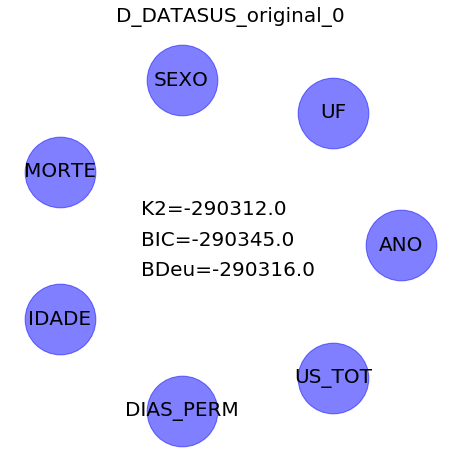

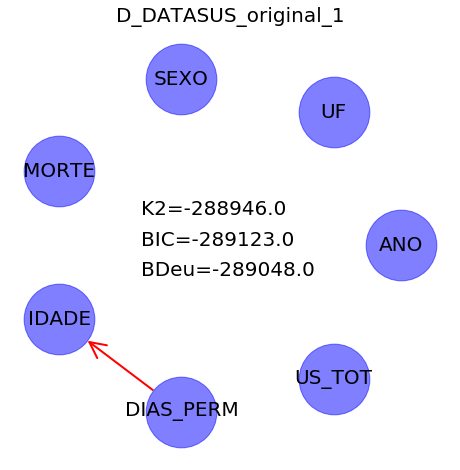

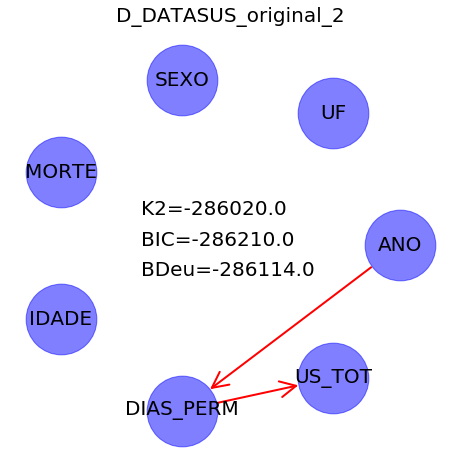

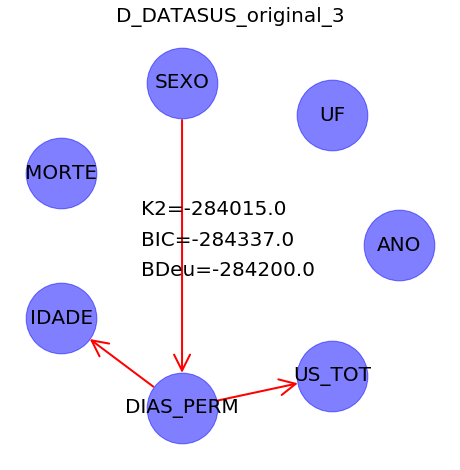

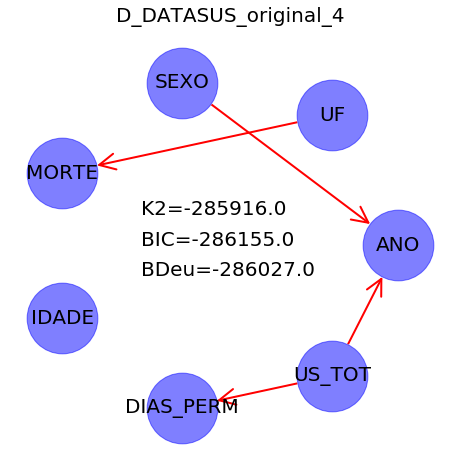

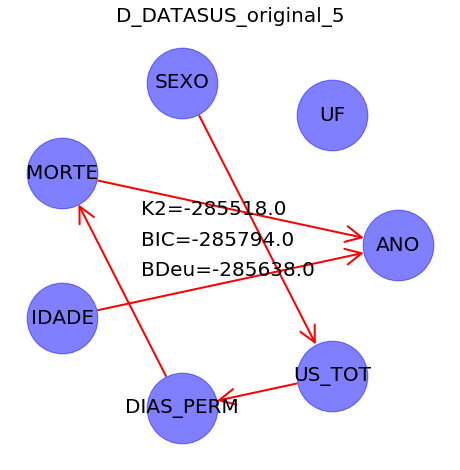

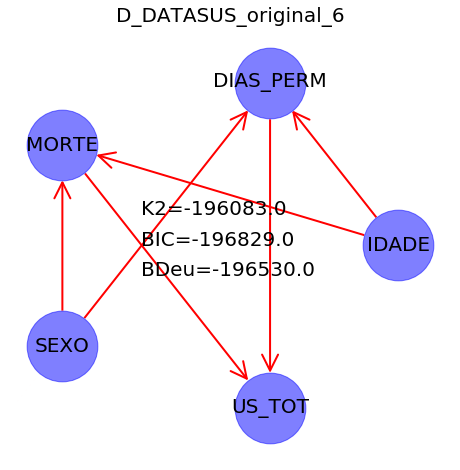

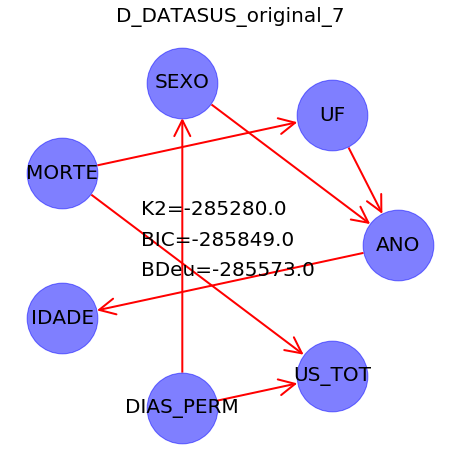

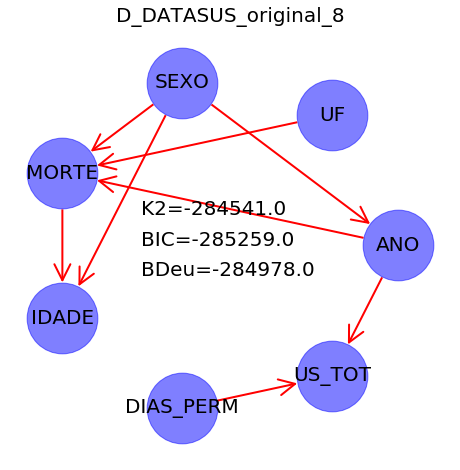

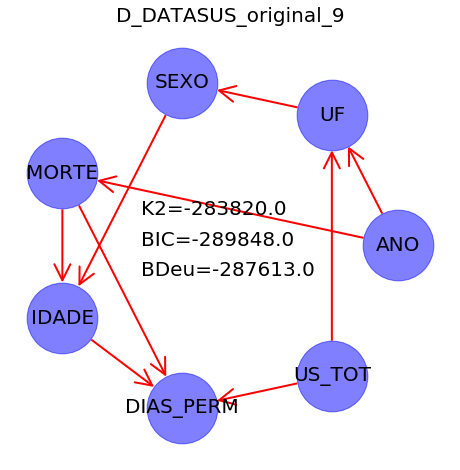

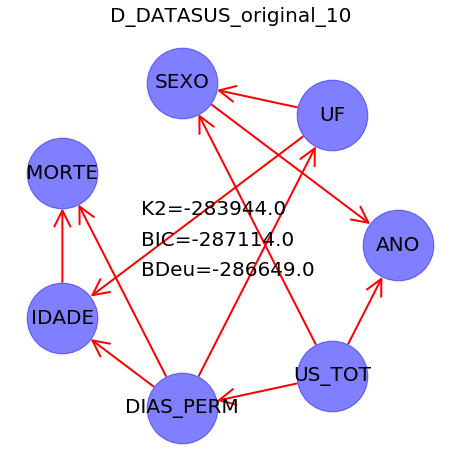

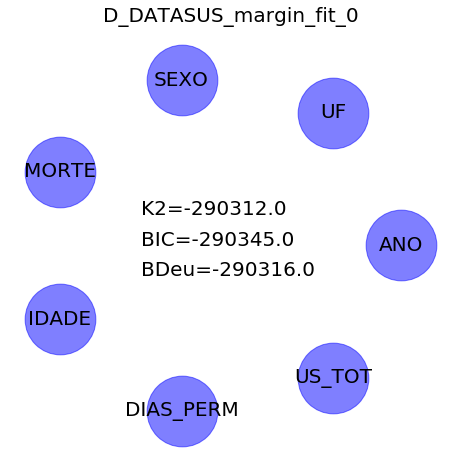

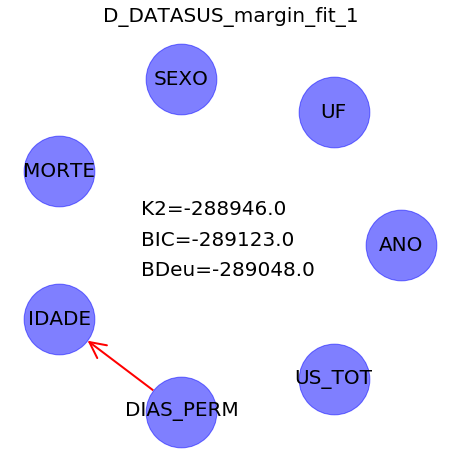

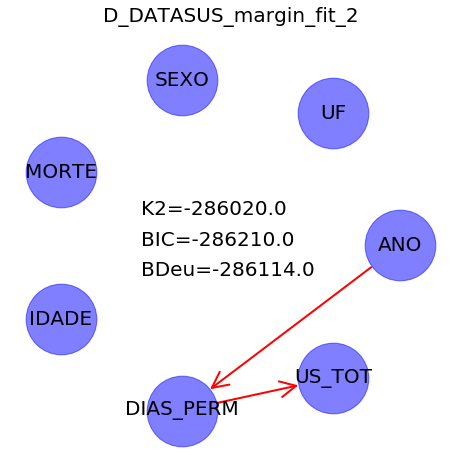

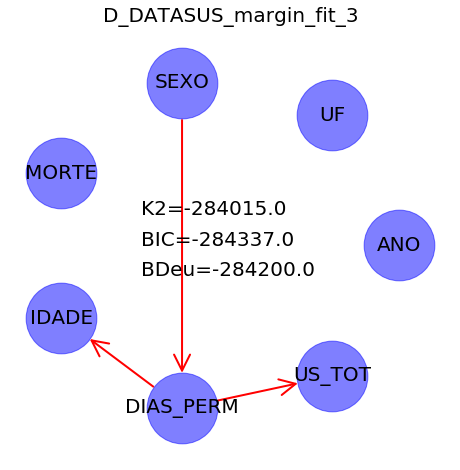

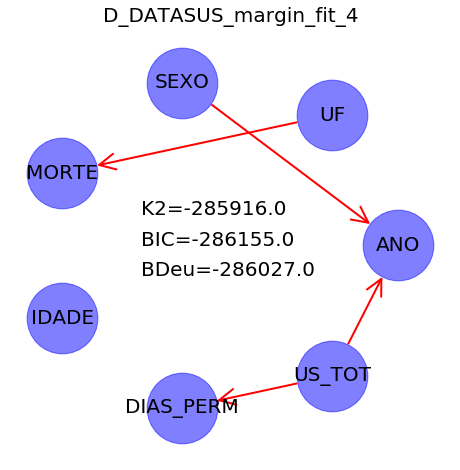

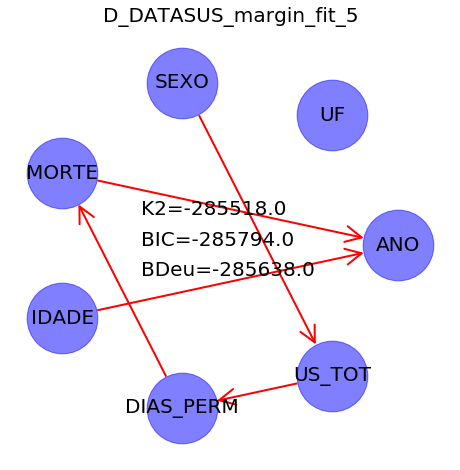

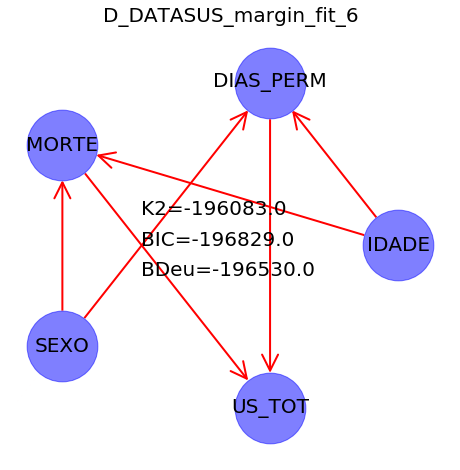

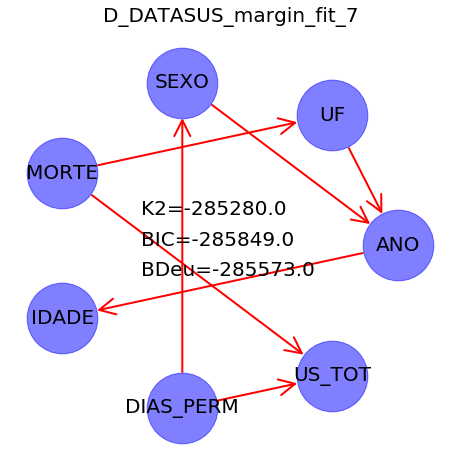

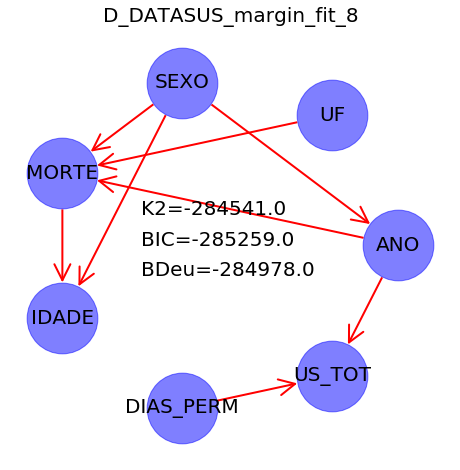

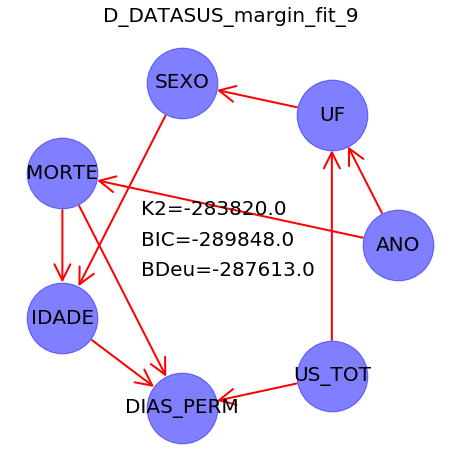

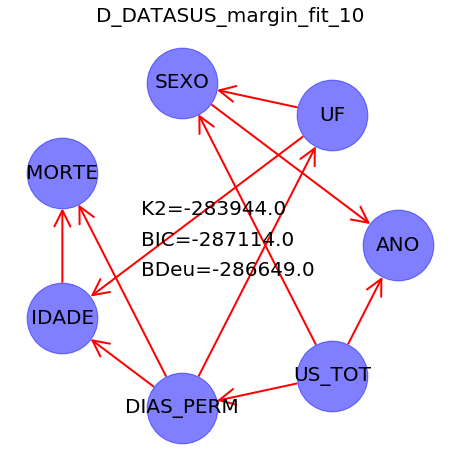

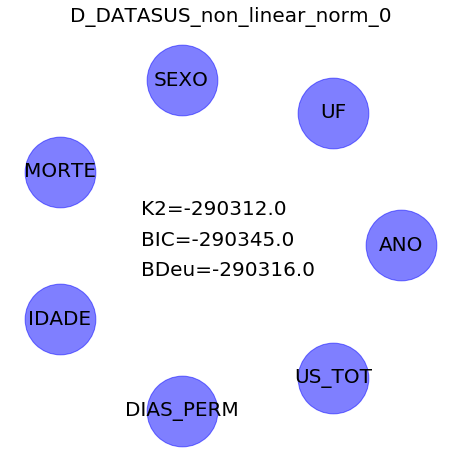

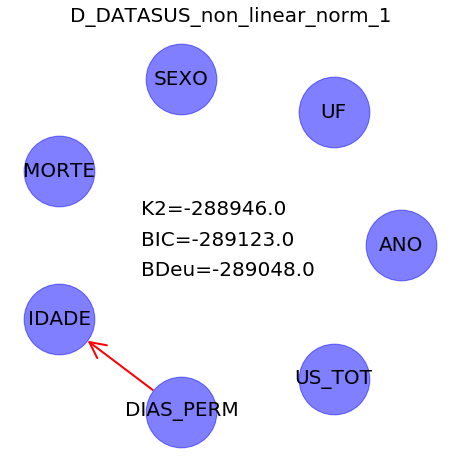

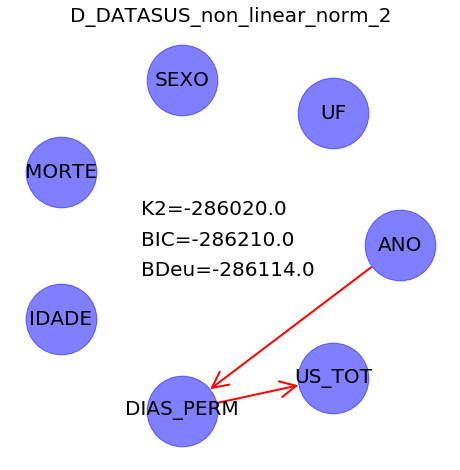

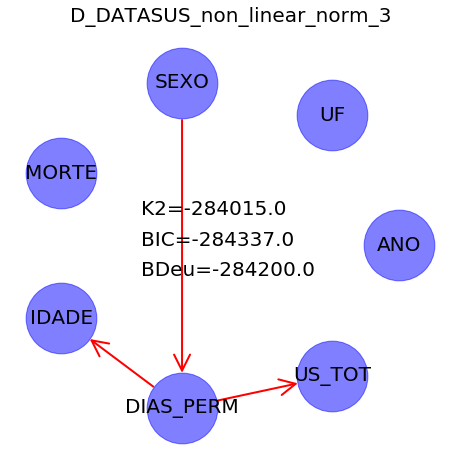

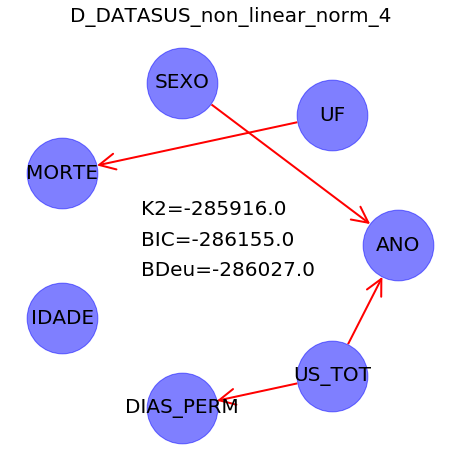

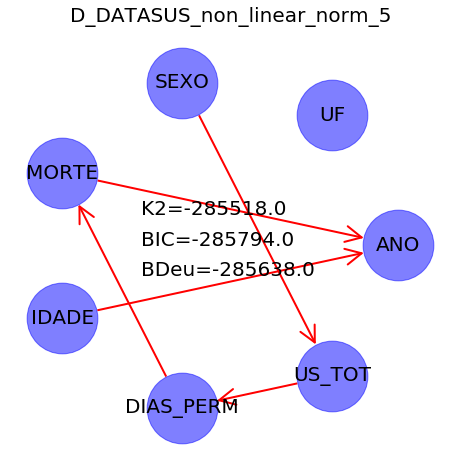

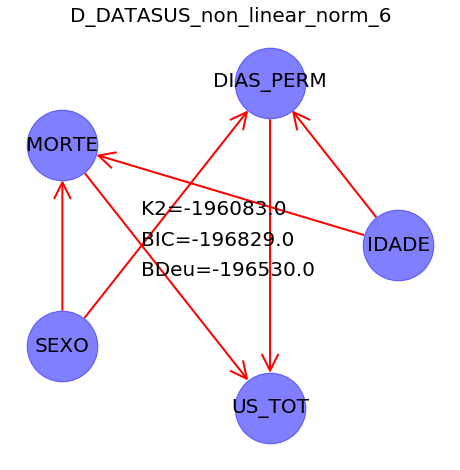

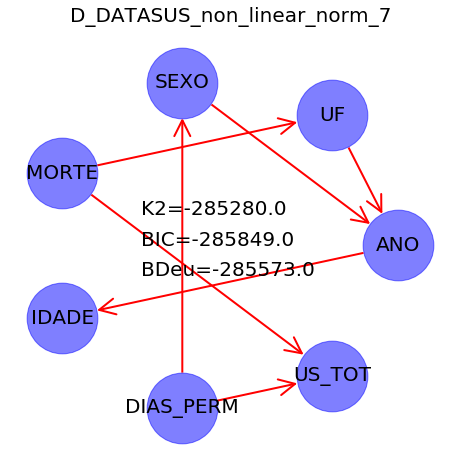

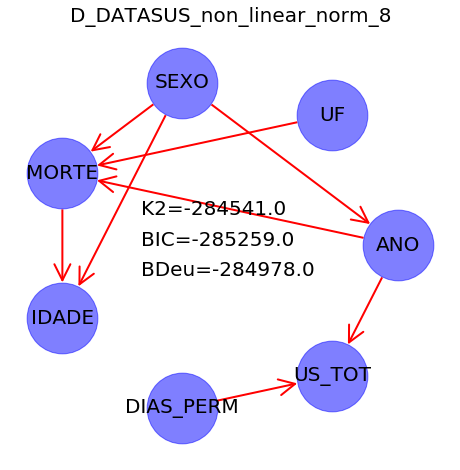

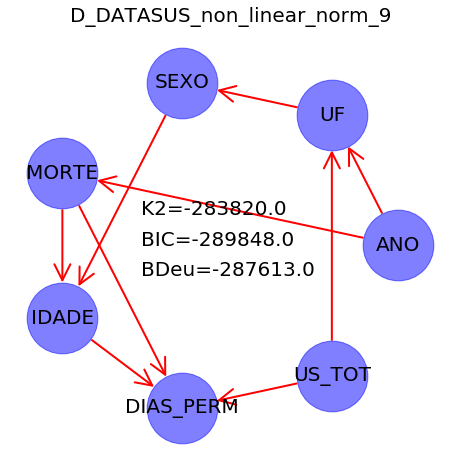

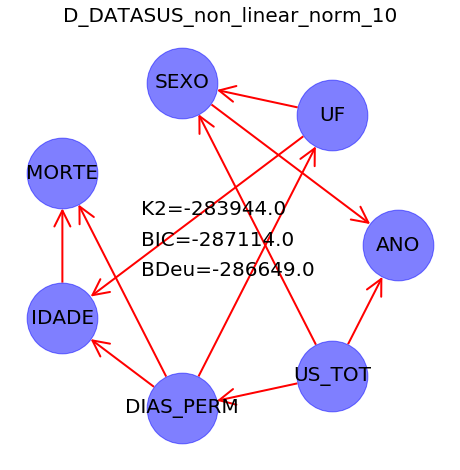

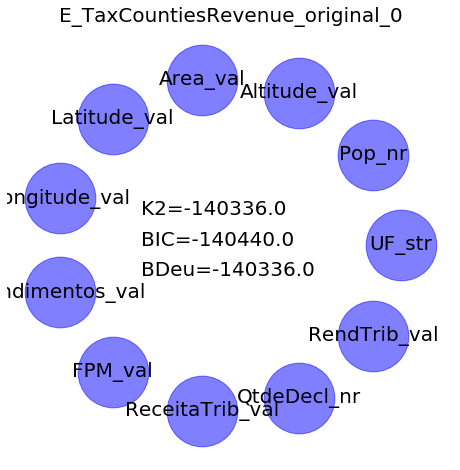

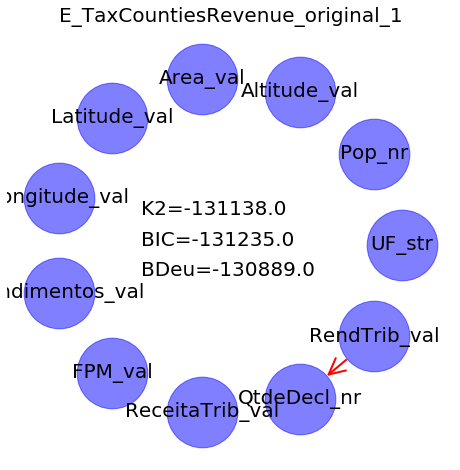

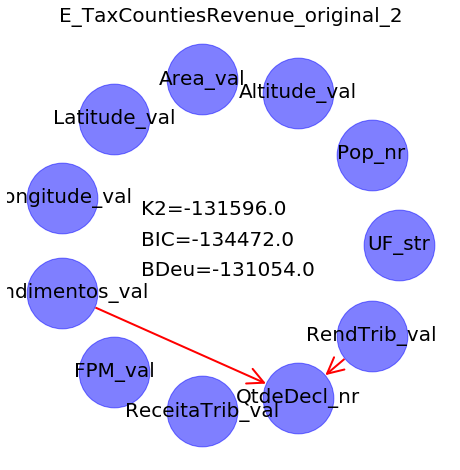

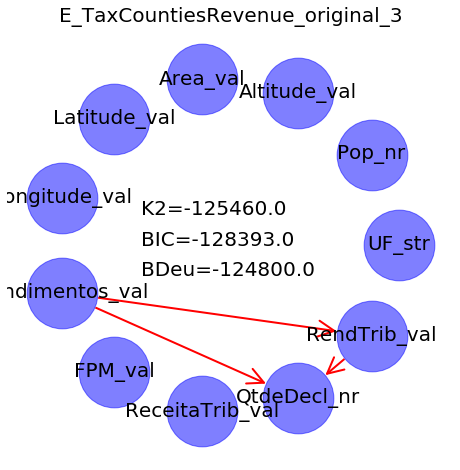

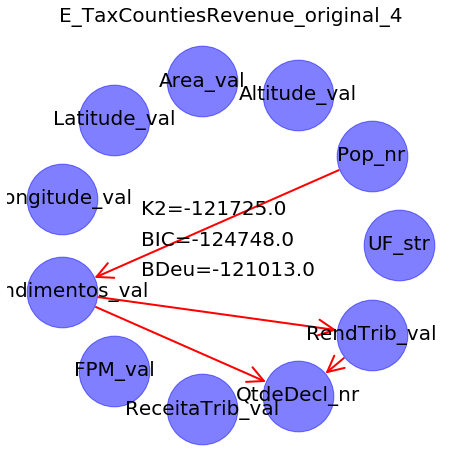

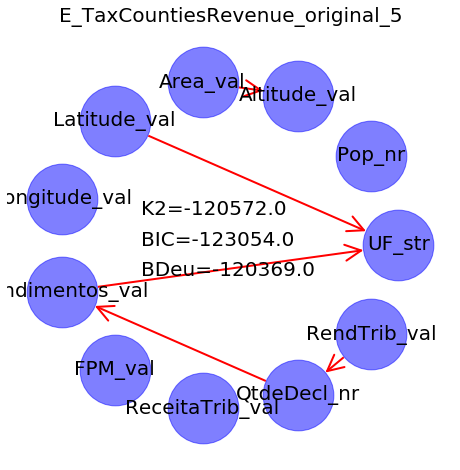

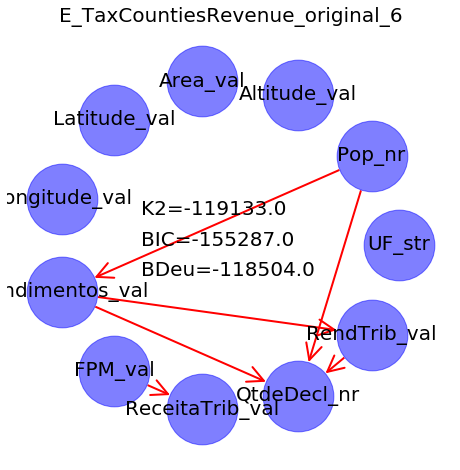

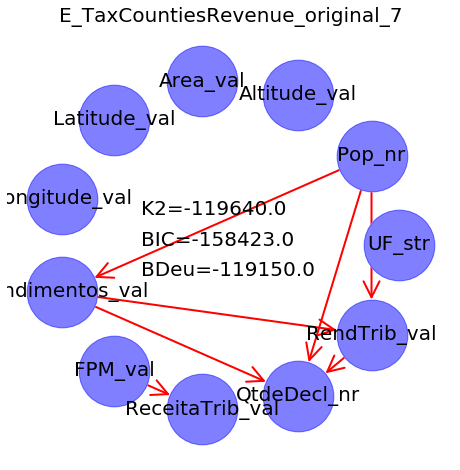

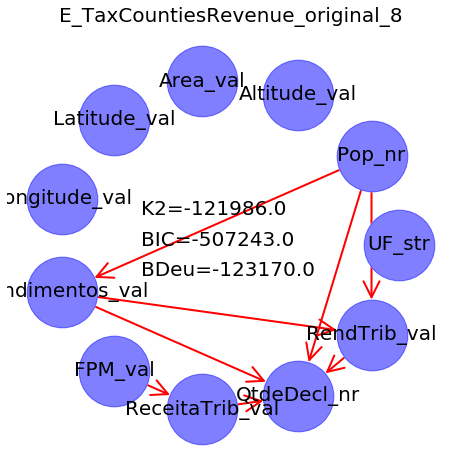

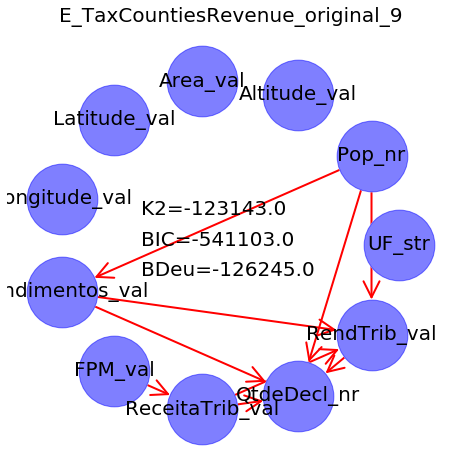

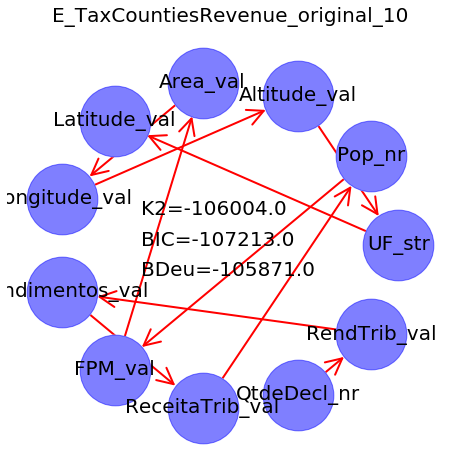

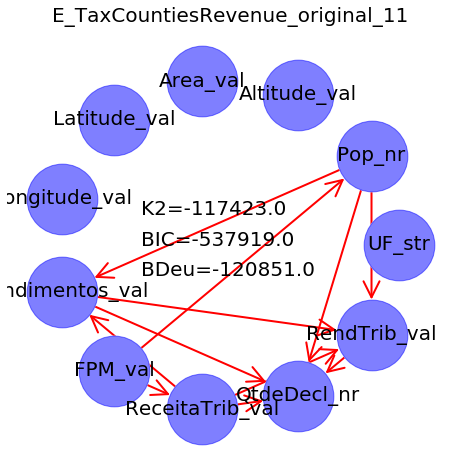

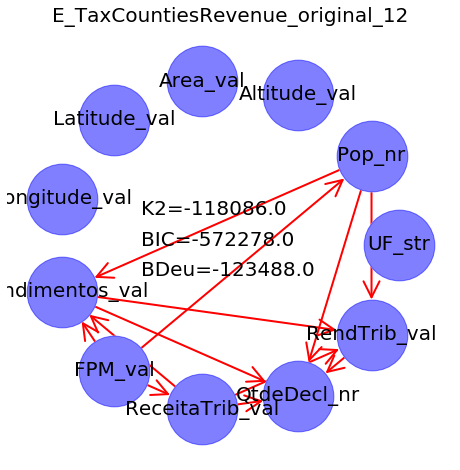

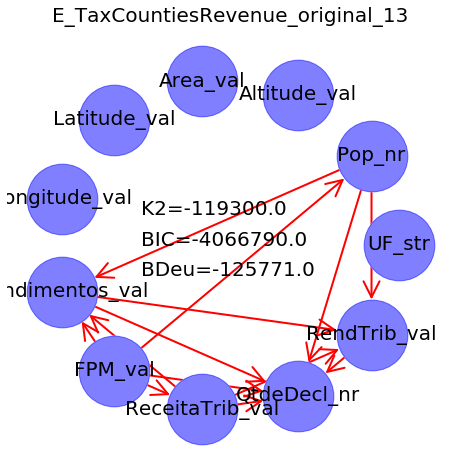

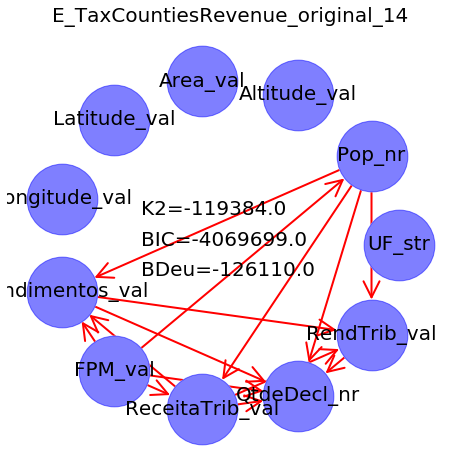

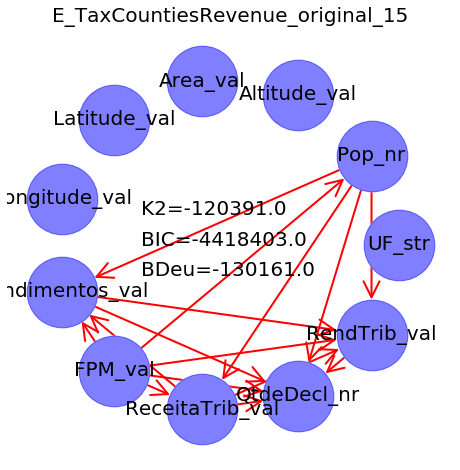

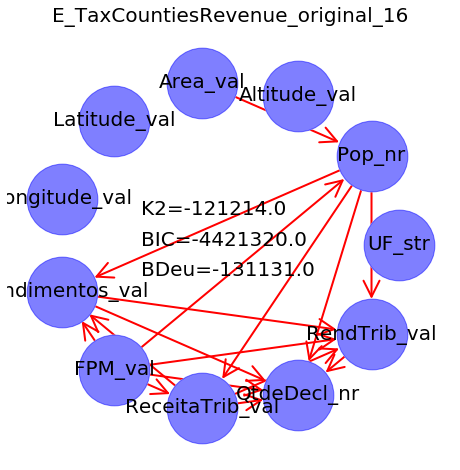

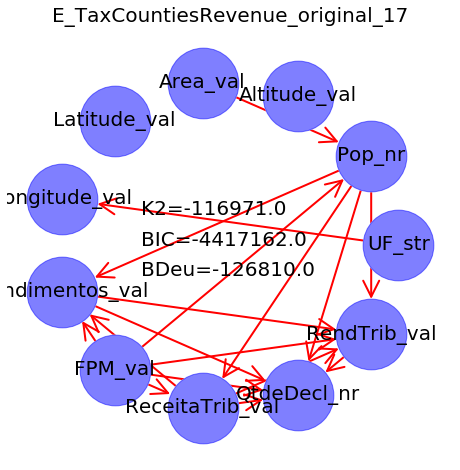

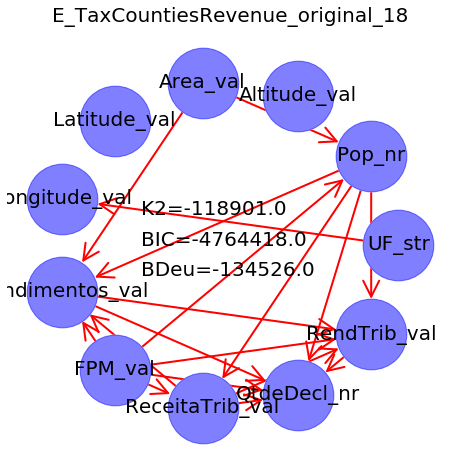

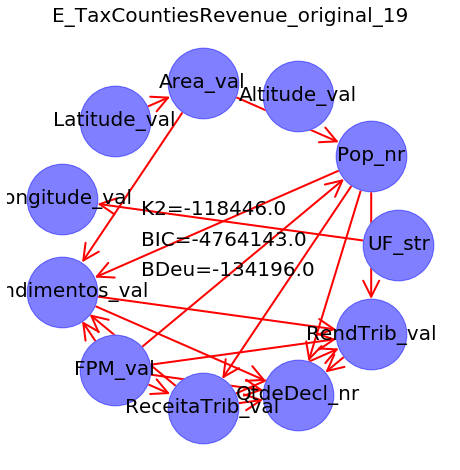

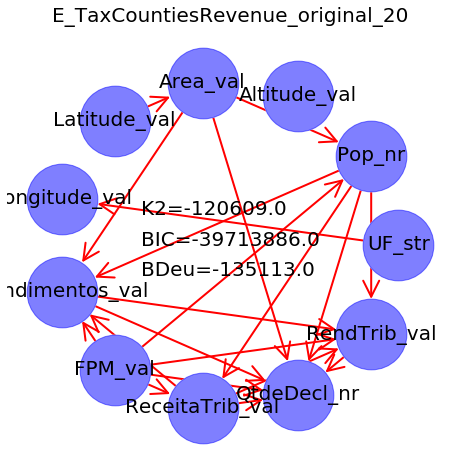

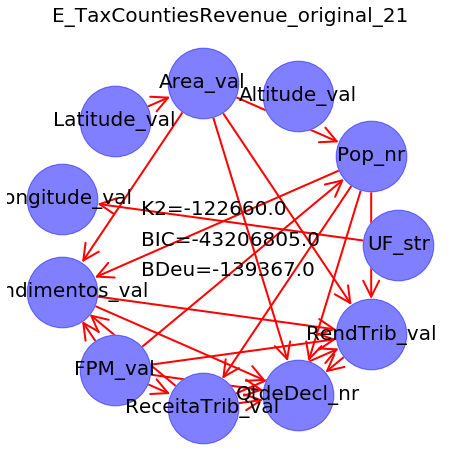

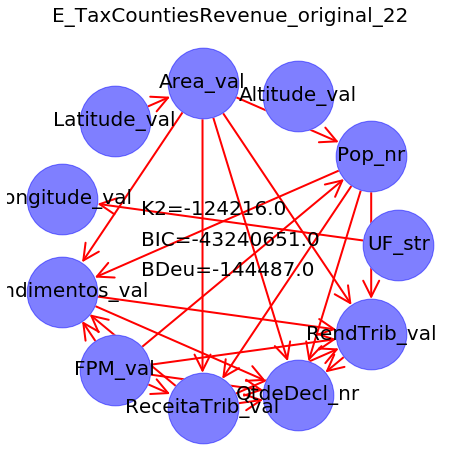

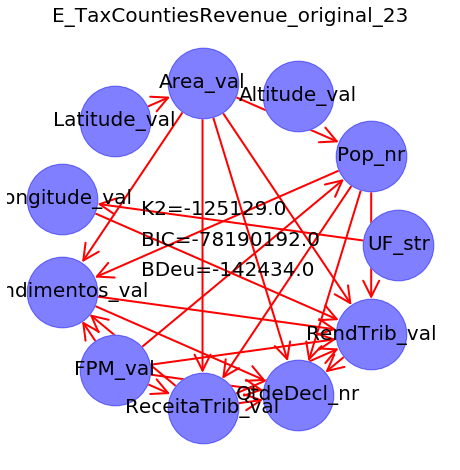

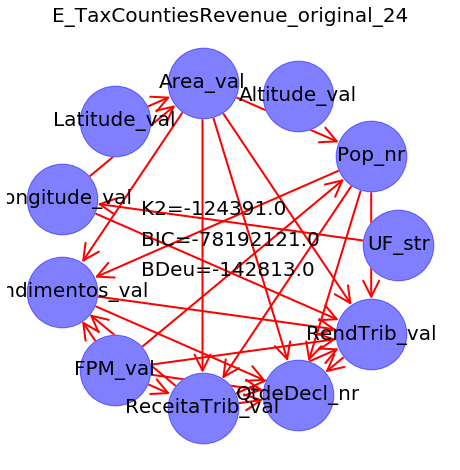

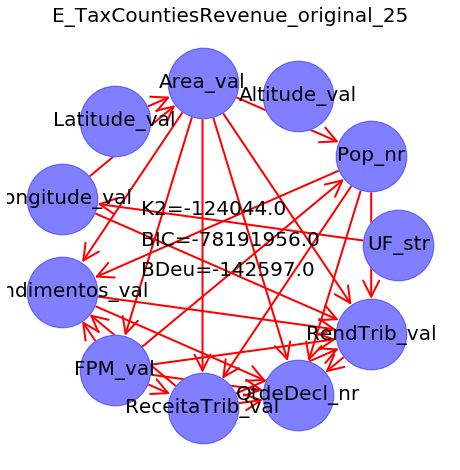

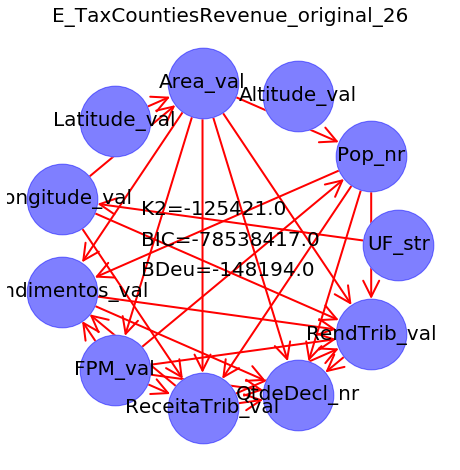

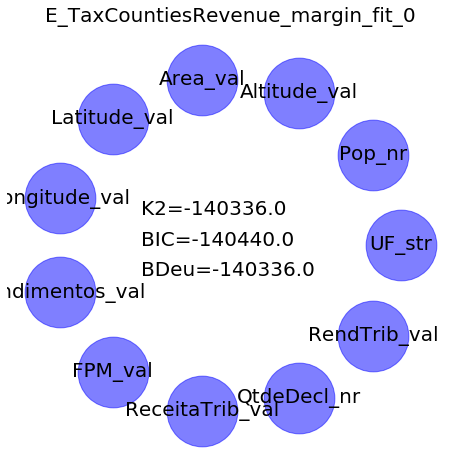

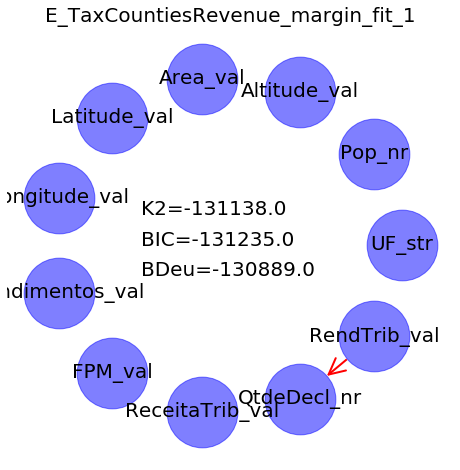

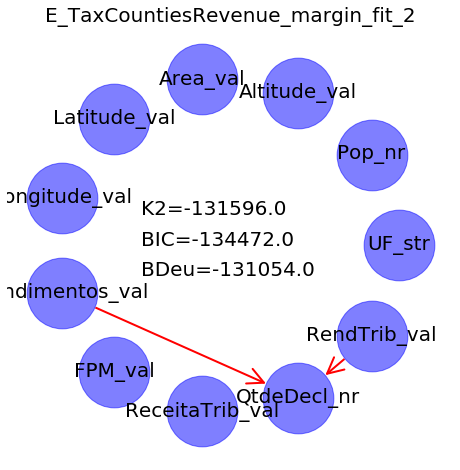

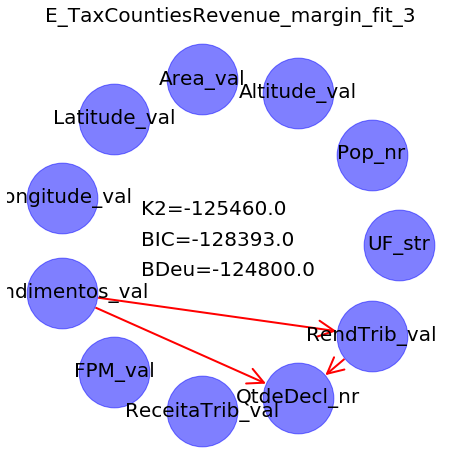

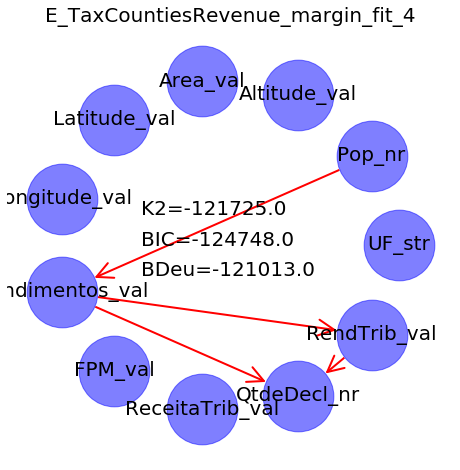

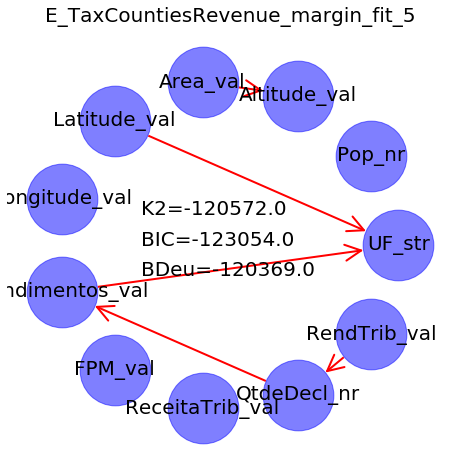

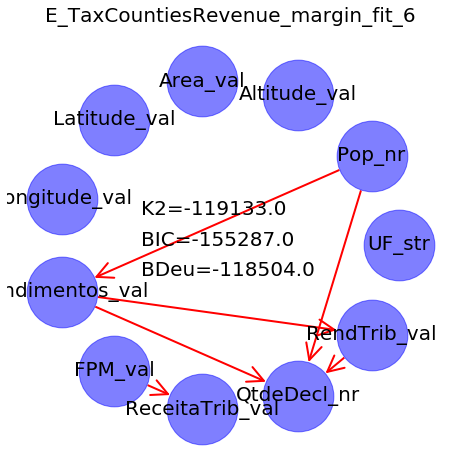

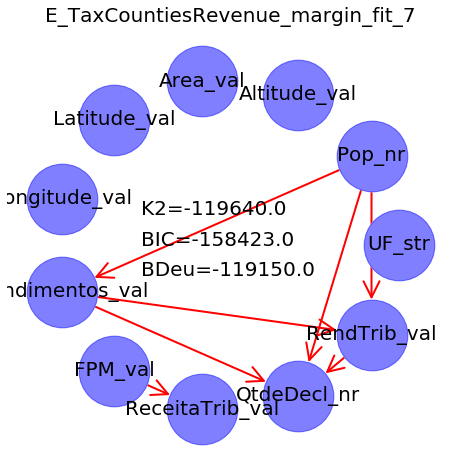

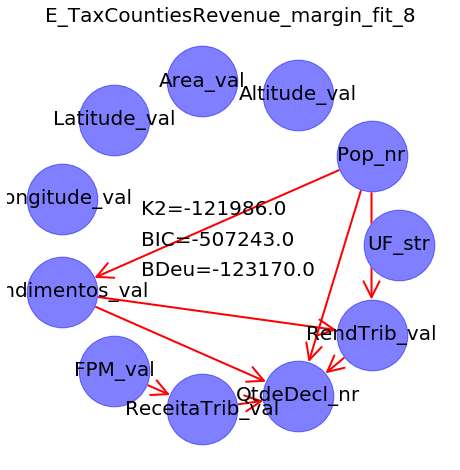

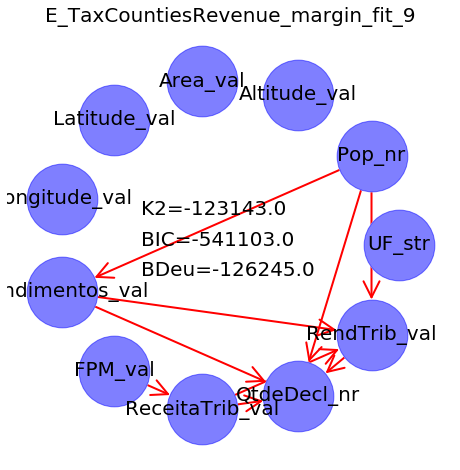

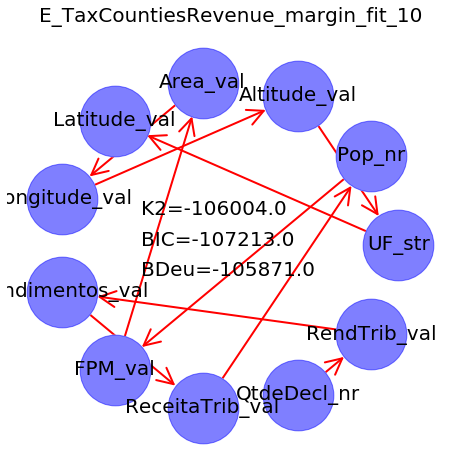

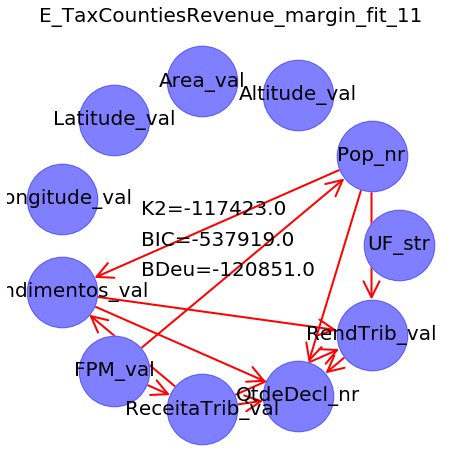

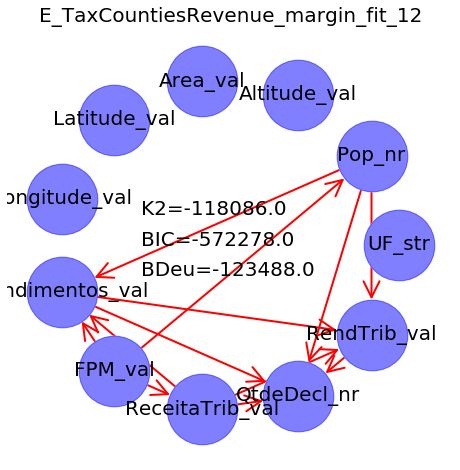

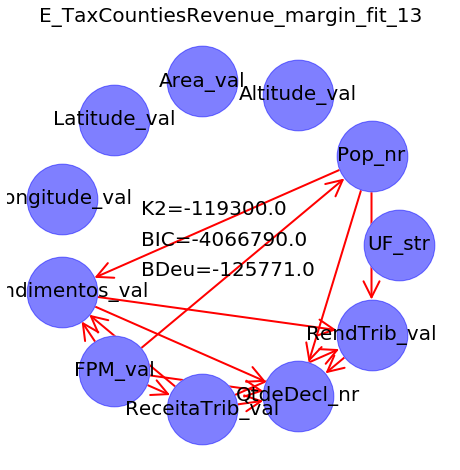

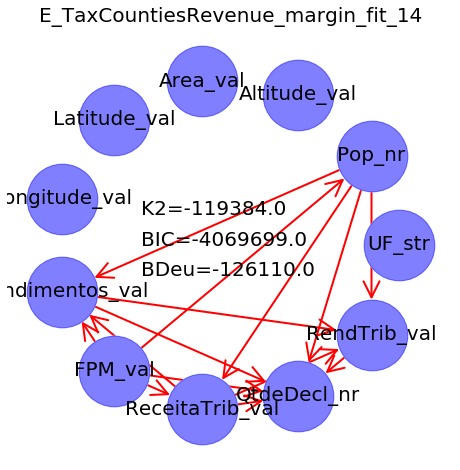

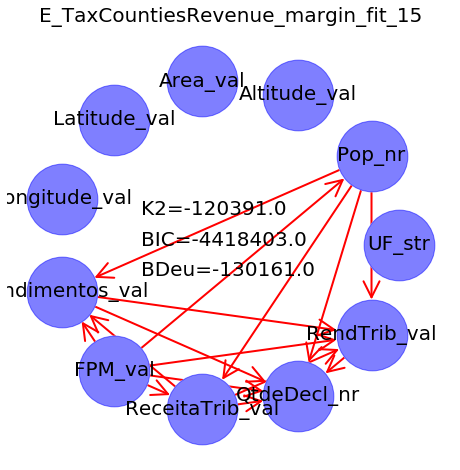

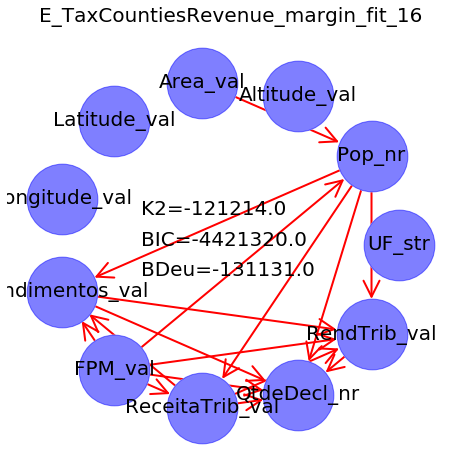

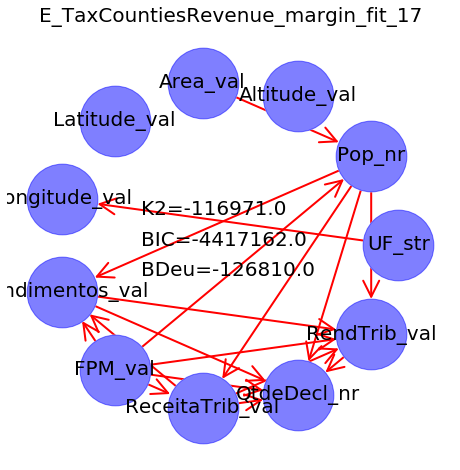

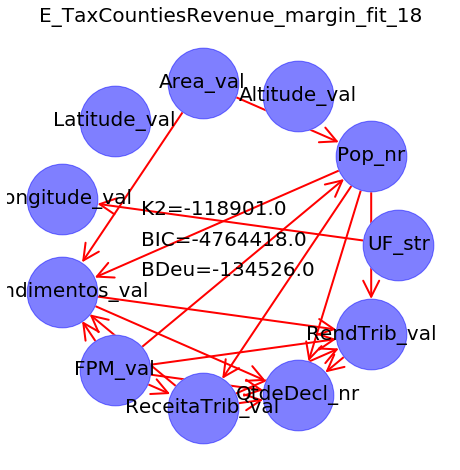

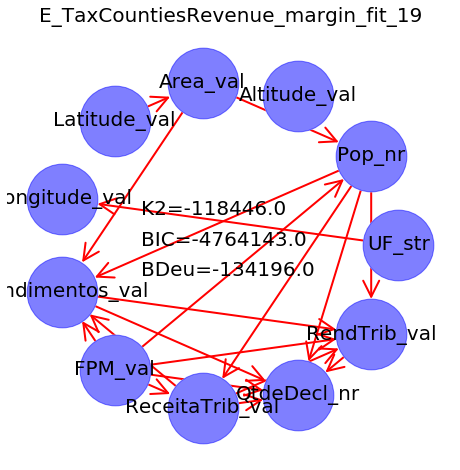

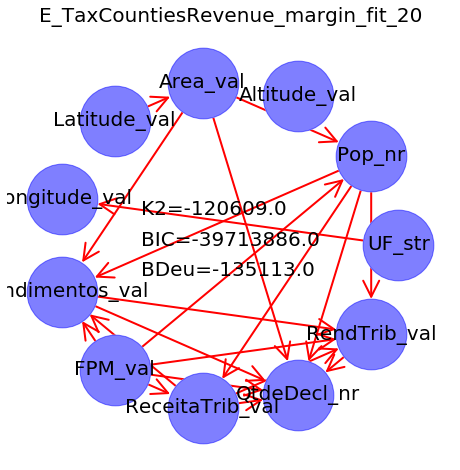

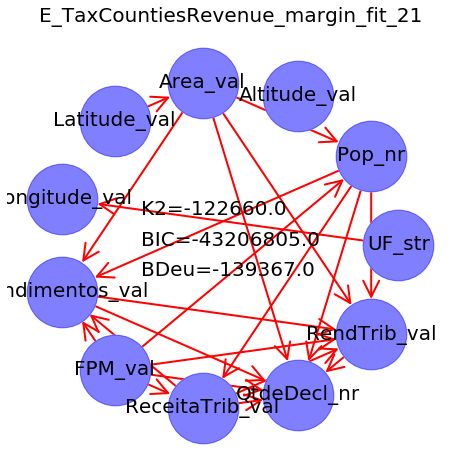

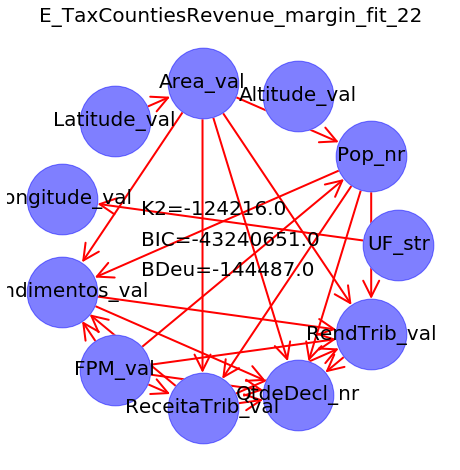

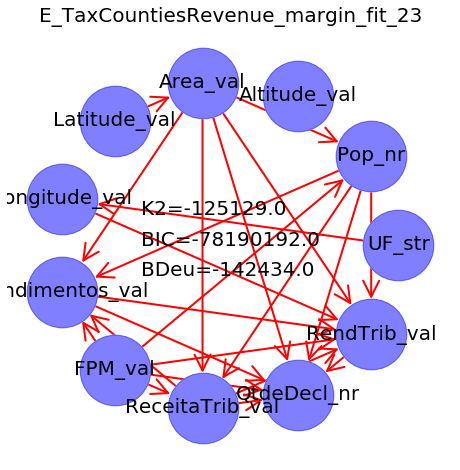

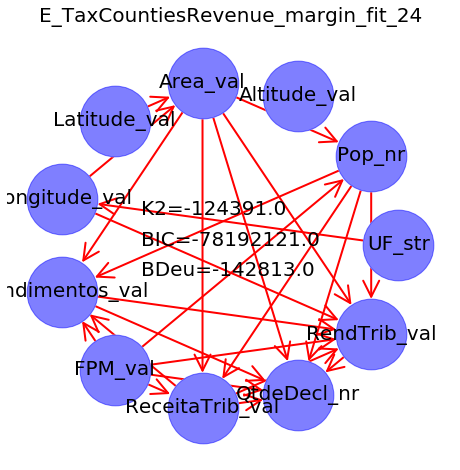

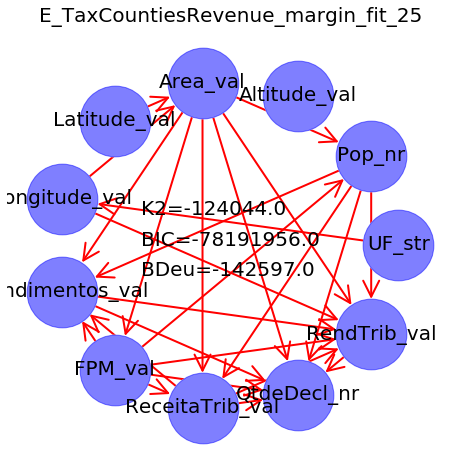

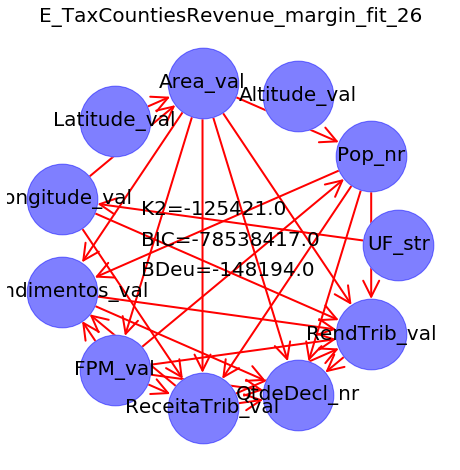

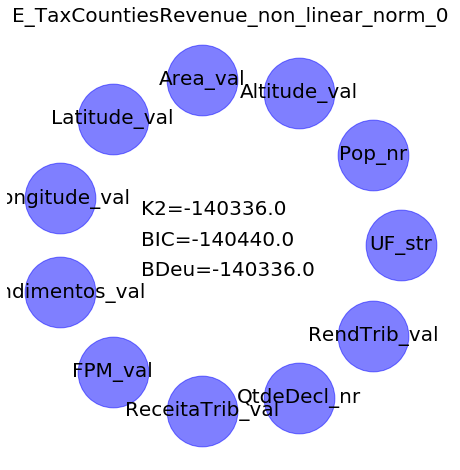

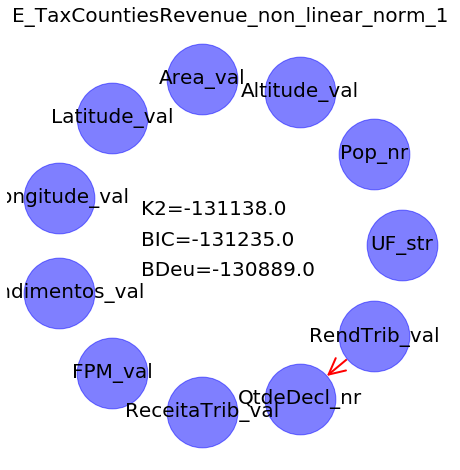

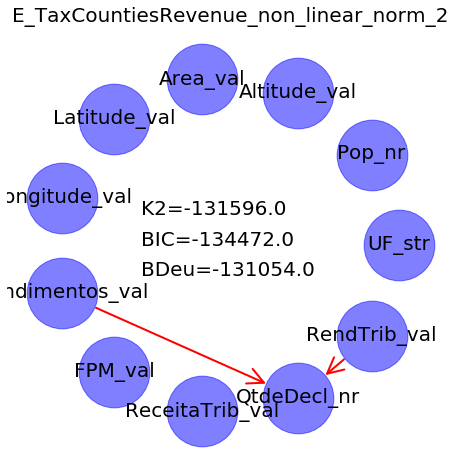

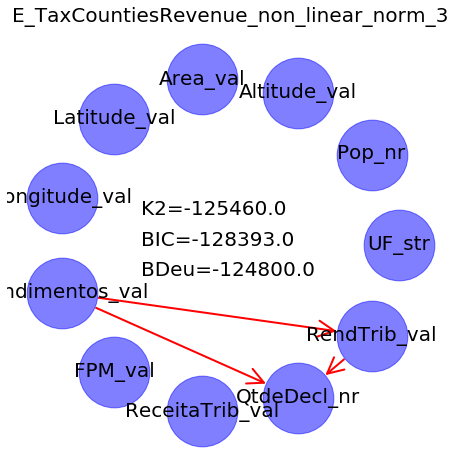

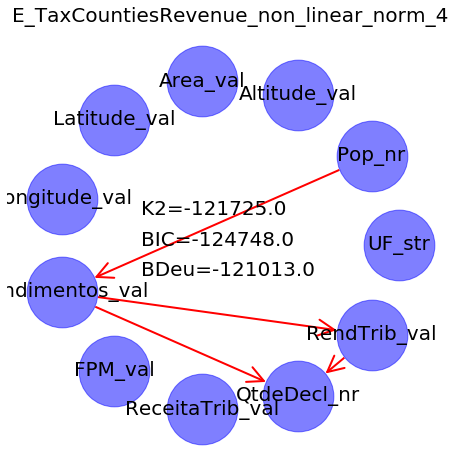

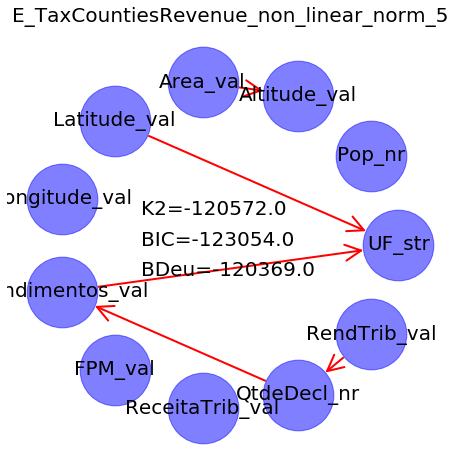

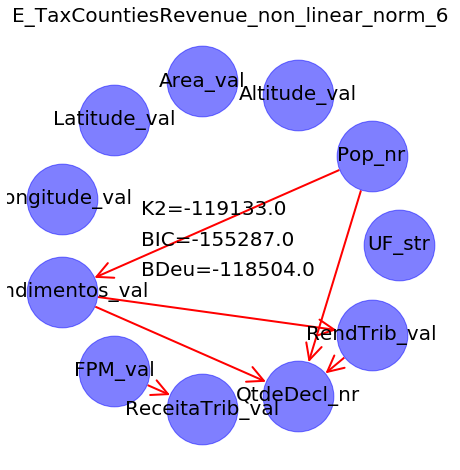

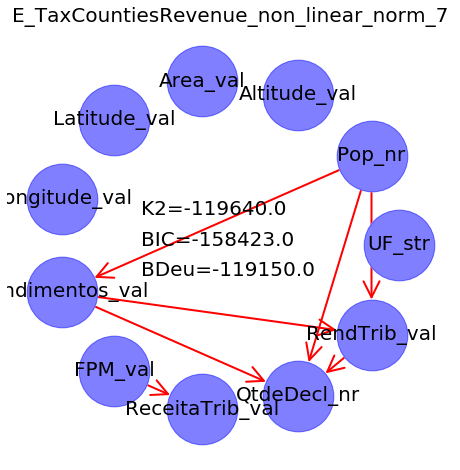

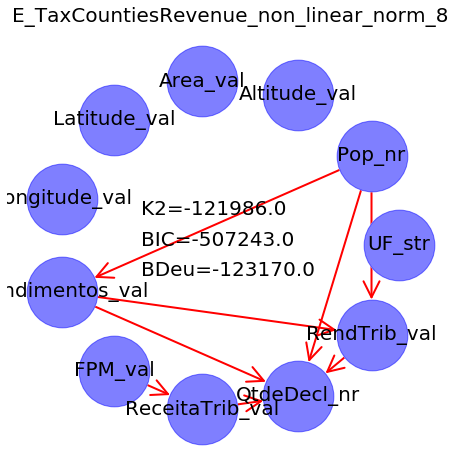

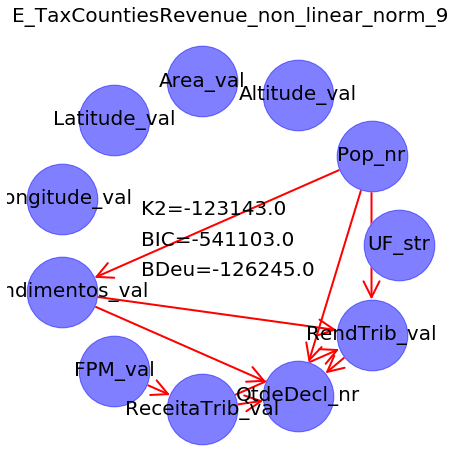

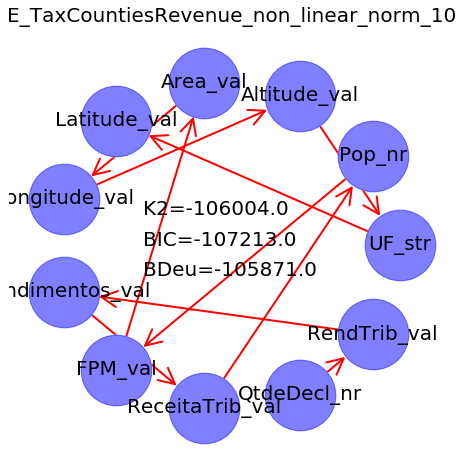

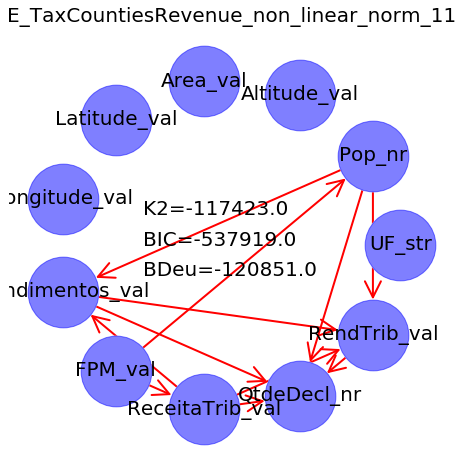

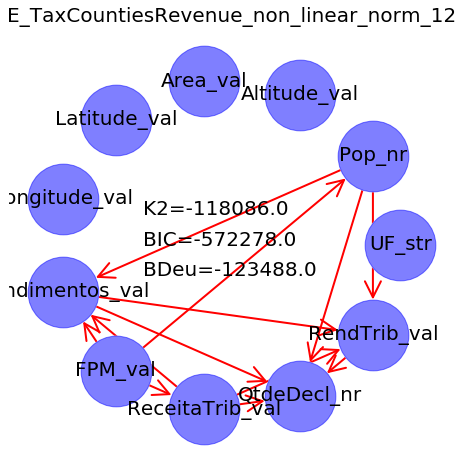

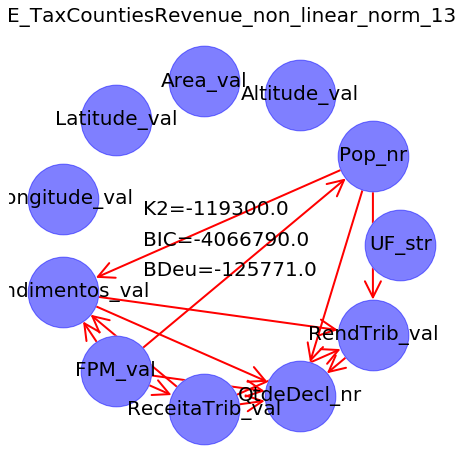

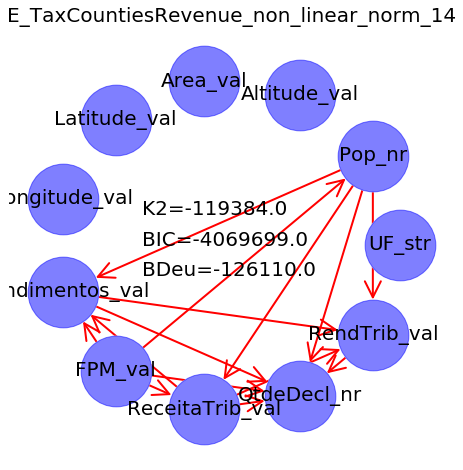

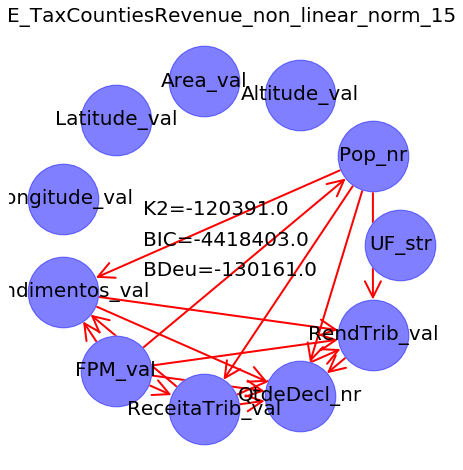

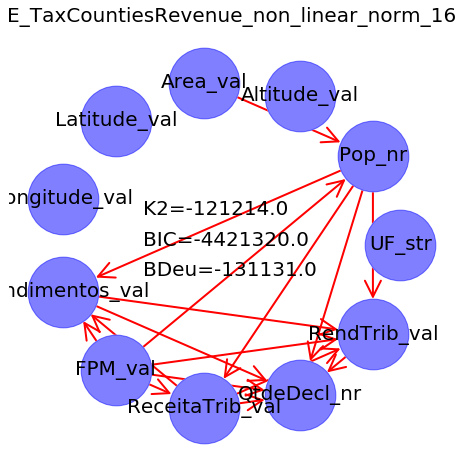

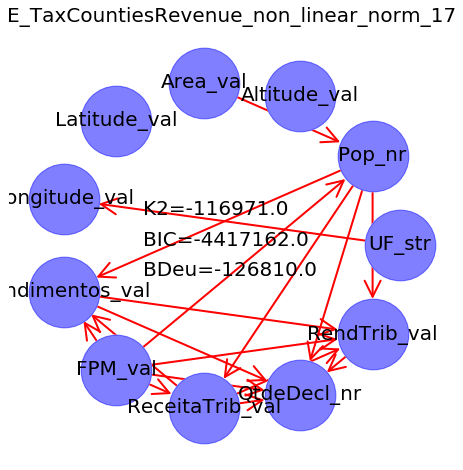

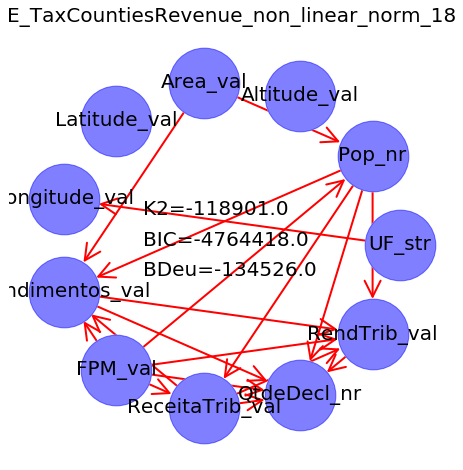

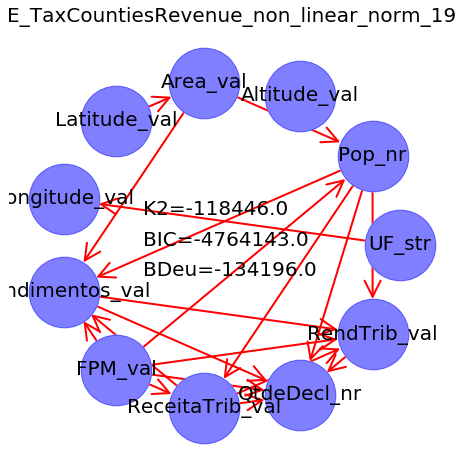

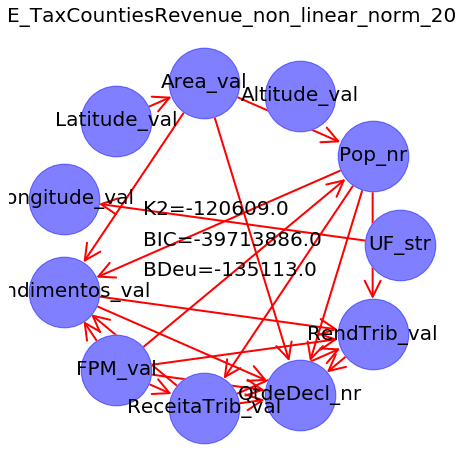

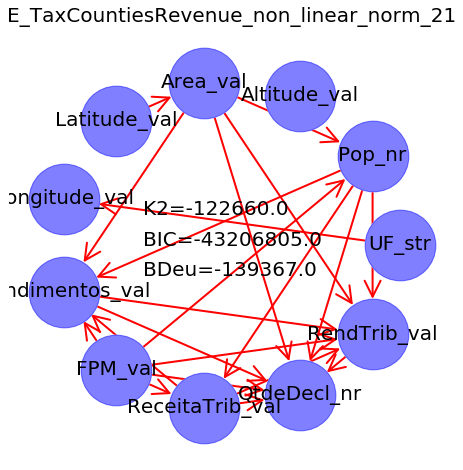

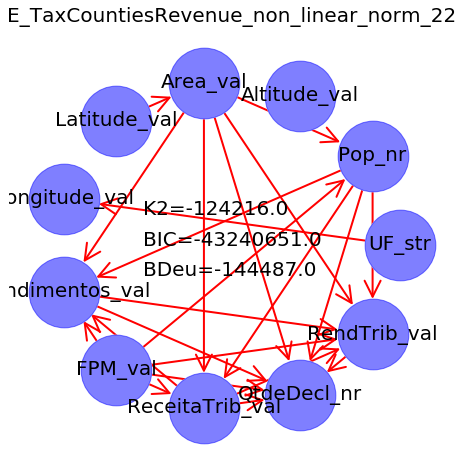

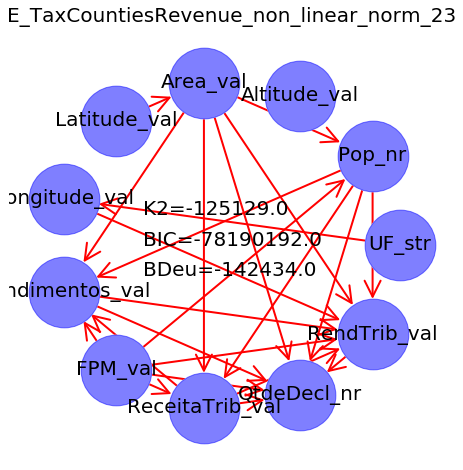

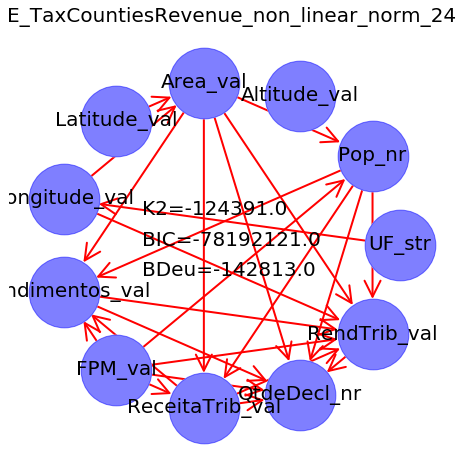

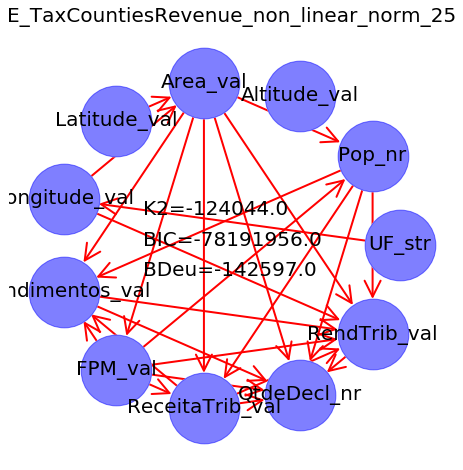

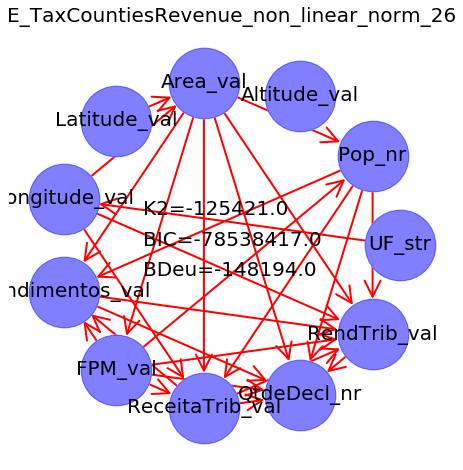

In [121]:
for dataset_name in scores_dic.keys():
    if dataset_name[0] in ['A', 'B', 'C']:
        dataset_norm_type_list = ['original', 'margin_gen_fit', 'margin_fit', 'non_linear_norm']
    else:
        dataset_norm_type_list = ['original', 'margin_fit', 'non_linear_norm']
    dag_group = data[dataset_name].dag_group
    norm_best = {}
    # identify best scored dags for each edges number
    for norm_type in dataset_norm_type_list:
        best_dags = []
        for dag_nr_name in scores_dic[dataset_name].keys():
            score_max, dag_nr_max, dag_max = -np.inf, '', ''
            dag_name_list = list(scores_dic[dataset_name][dag_nr_name].keys())
            if len(dag_name_list)>0:
                for dag_name in dag_name_list:
                    score = scores_dic[dataset_name][dag_nr_name][dag_name][norm_type][2]
                    if score>score_max:
                        dag_nr_max, dag_max = dag_nr_name, dag_name
                        score_max = score
                dag = score_dags[dag_group][dag_nr_max][dag_max]
                scores = scores_dic[dataset_name][dag_nr_max][dag_max][norm_type]
                best_dags.append({'dag_nr':dag_nr_name, 'dag':dag, 'scores':scores})
        norm_best[norm_type] = best_dags
    # plot best scored dags score x number of edges
    fig, ax = plt.subplots()
    plt.xticks(rotation=90)
    for norm_type in dataset_norm_type_list:
        best_dags = norm_best[norm_type]
        dag_nrs = [best_dags[i]['dag_nr'] for i in range(len(best_dags))]
        scores = [best_dags[i]['scores'][2] for i in range(len(best_dags))]
        ax.plot(dag_nrs, scores, 'o', label=norm_type)
    ax.legend() #loc=(0.7,.05))
    ax.set_title(dataset_name+' - best DAG for edge_nr ranking')
    ax.set_xlabel('edges number')
    ax.set_ylabel('score')
    fig.savefig(fig_dir+dataset_name+'_dag_nr_best_rank.png')
    plt.close(fig)
    # plot best scored dags
    for norm_type in dataset_norm_type_list:
        for d in best_dags:
            plotBNet(d['dag'], d['scores'], dataset_name, norm_type+'_'+d['dag_nr'])

#### 3.2.6. Scores Comparison

In [122]:
score_rank_dic = {}
for dataset_name in scores_dic.keys():
    if dataset_name[0] in ['A', 'B', 'C']:
        dataset_norm_type_list = ['original', 'margin_gen_fit', 'margin_fit', 'non_linear_norm']
    else:
        dataset_norm_type_list = ['original', 'margin_fit', 'non_linear_norm']
    score_cols = ['dag_name'] + dataset_norm_type_list
    dataset_scores_df = pd.DataFrame(columns=score_cols)
    for dag_nr_name in scores_dic[dataset_name].keys():
        for dag_name in scores_dic[dataset_name][dag_nr_name].keys():
            reg = [dag_name]
            dag_dic = scores_dic[dataset_name][dag_nr_name][dag_name]
            for norm_type in dataset_norm_type_list:
                score = dag_dic[norm_type][2]
                reg.append(score)
            dataset_scores_df.loc[len(dataset_scores_df)] = reg
    dataset_scores_df.sort_values('original', ascending=True, inplace=True)
    score_rank_dic[dataset_name] = dataset_scores_df

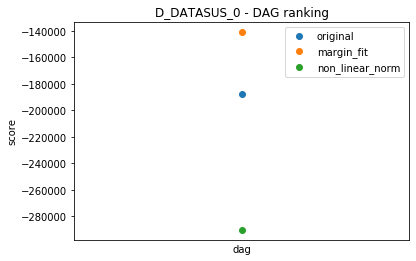

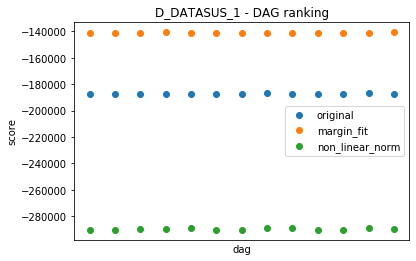

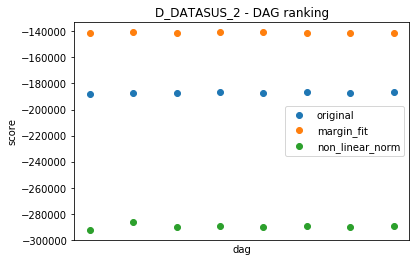

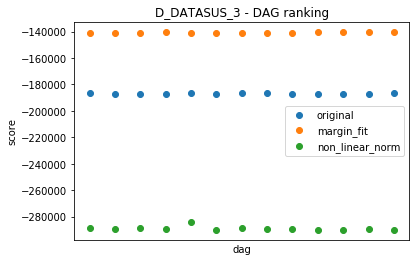

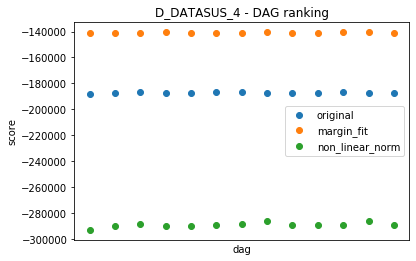

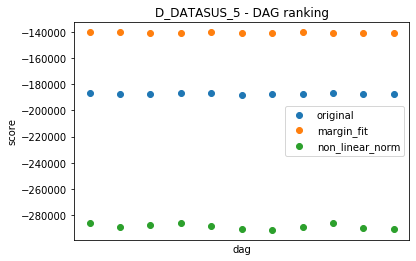

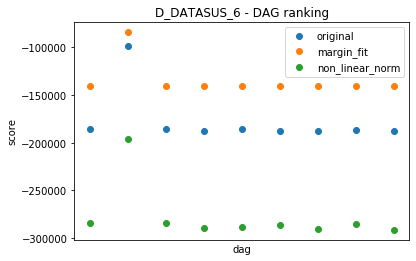

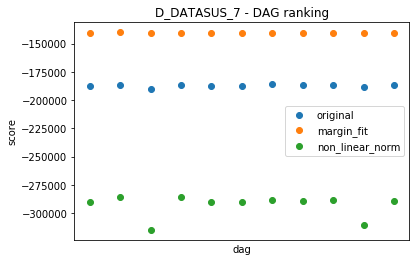

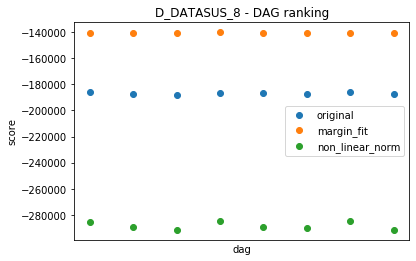

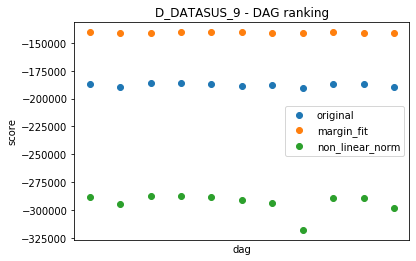

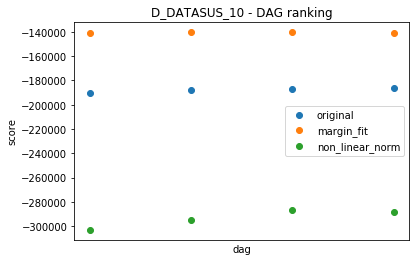

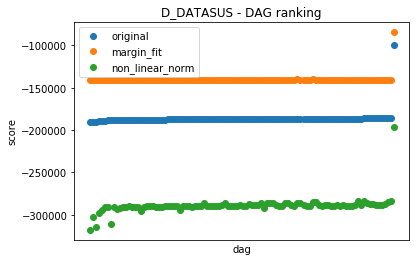

/home/willian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/willian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


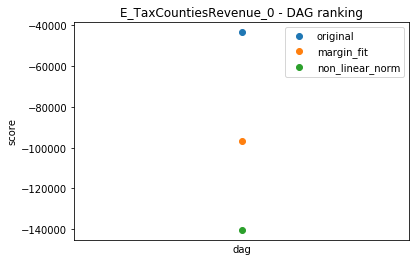

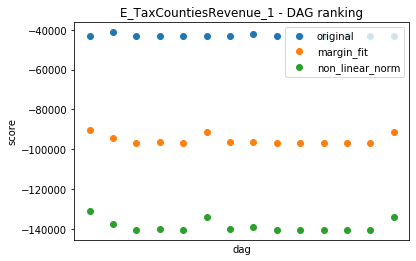

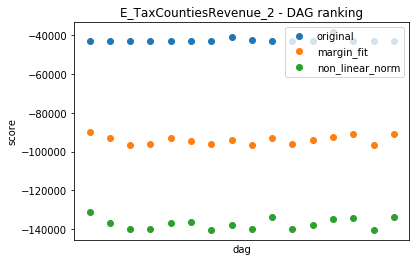

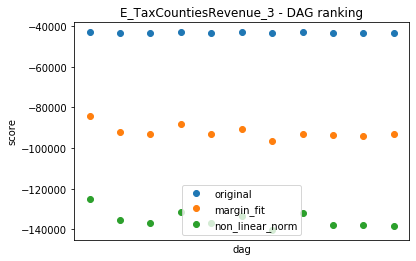

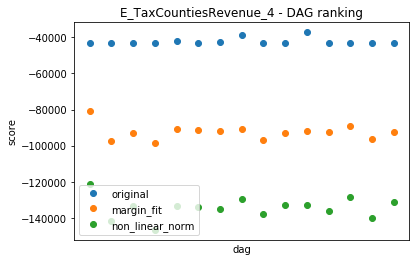

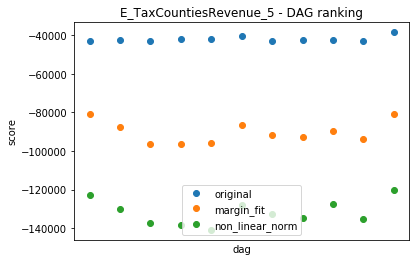

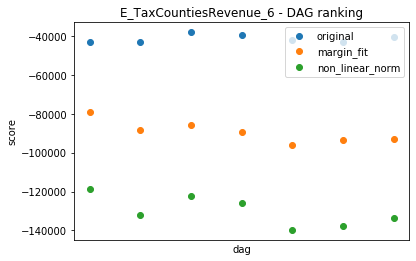

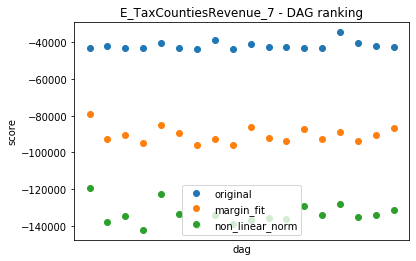

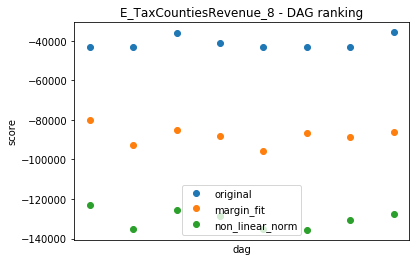

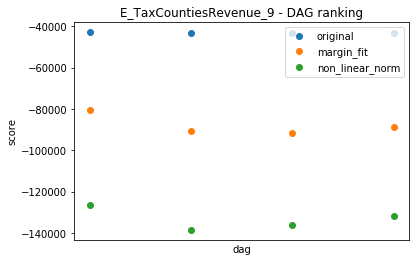

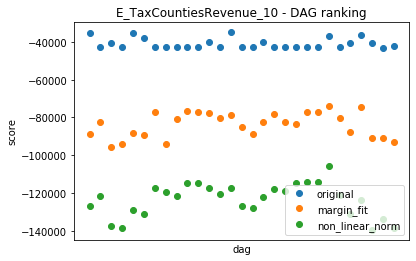

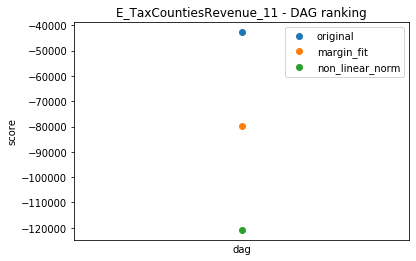

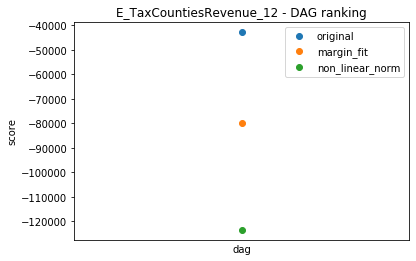

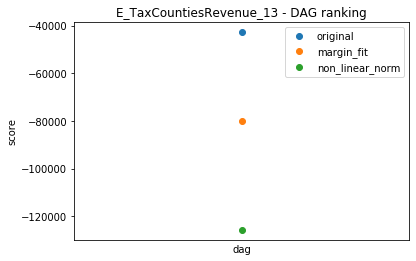

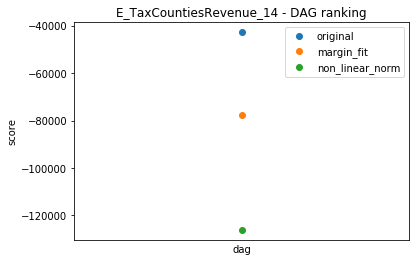

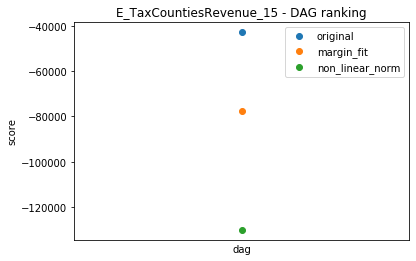

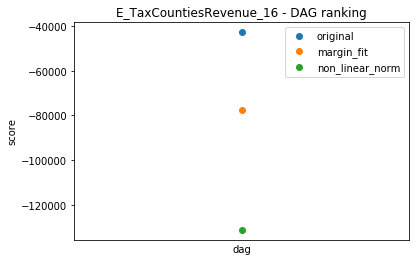

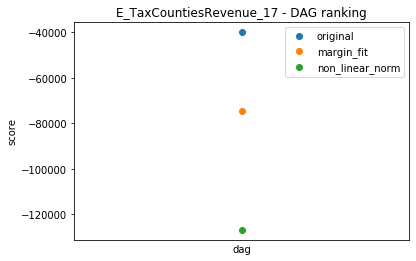

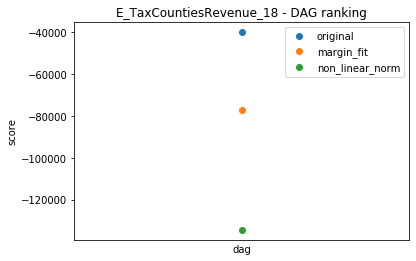

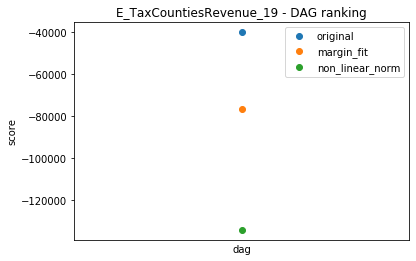

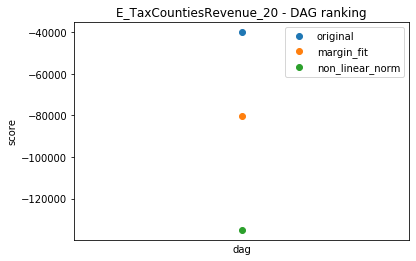

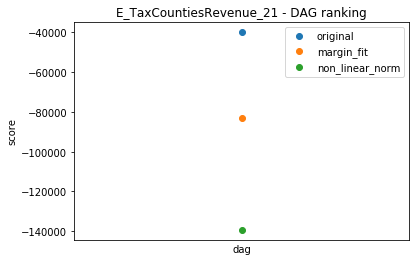

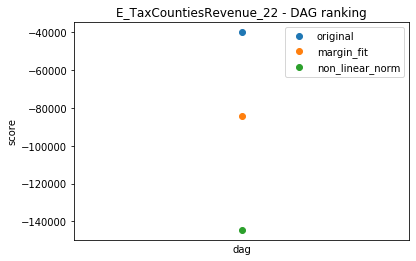

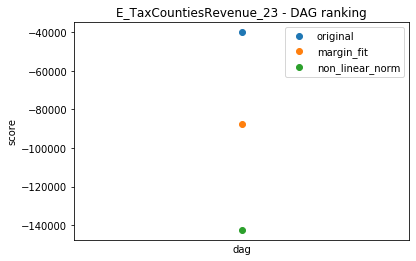

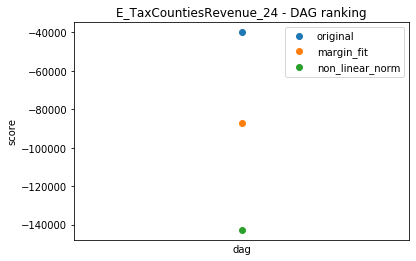

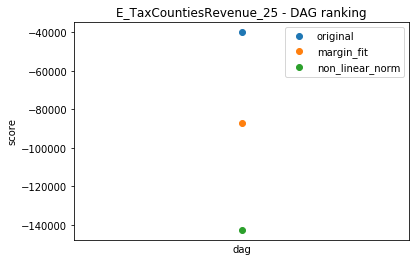

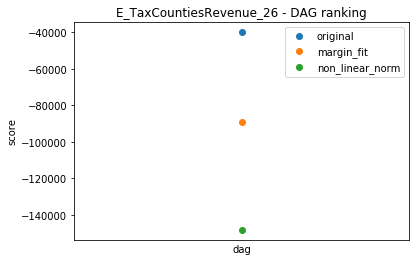

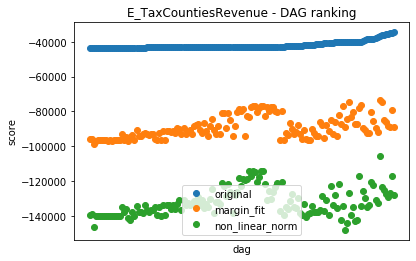

In [123]:
for dataset_name in dataset_name_list:
    if dataset_name[0] in ['A', 'B', 'C']:
        dataset_norm_type_list = ['original', 'margin_gen_fit', 'margin_fit', 'non_linear_norm']
    else:
        dataset_norm_type_list = ['original', 'margin_fit', 'non_linear_norm']
    score_cols = ['dag_name'] + dataset_norm_type_list
    dataset_scores_df = score_rank_dic[dataset_name]
    for dag_nr_name in scores_dic[dataset_name].keys():
        dags = list(scores_dic[dataset_name][dag_nr_name].keys())
        if len(dags)>0:
            scores = {}
            for norm_type in dataset_norm_type_list:
                scores_dag = []
                for dag in dags:
                    scores_dag.append(scores_dic[dataset_name][dag_nr_name][dag][norm_type][2])
                scores[norm_type] = scores_dag
            fig, ax = plt.subplots()
            plt.xticks(rotation=90)
            for norm_type in norm_type_list:
                if (norm_type=='margin_gen_fit'):
                    ms, alpha = 12, 0.5
                else:
                    ms, alpha = 6, 1.0
                ax.plot(dags, scores[norm_type], 'o', label=norm_type, ms=ms, alpha=alpha)
            ax.legend() #loc=(0.7,.05))
            ax.set_title(dataset_name+'_'+dag_nr_name+' - DAG ranking')
            ax.set_xlabel('dag')
            ax.set_ylabel('score')
            ax.set_xticks([])
            fig.savefig(fig_dir+dataset_name+'_'+dag_nr_name+'_dag_rank.png')
            #plt.close(fig)
    dags = list(dataset_scores_df['dag_name'])
    fig, ax = plt.subplots()
    plt.xticks(rotation=90)
    for norm_type in norm_type_list:
        scores = list(dataset_scores_df[norm_type])
        if (norm_type=='margin_gen_fit'):
            ms, alpha = 12, 0.5
        else:
            ms, alpha = 6, 1.0
        ax.plot(dags, scores, 'o', label=norm_type, ms=ms, alpha=alpha)
    ax.legend() #loc=(0.7,.05))
    ax.set_title(dataset_name+' - DAG ranking')
    ax.set_xlabel('dag')
    ax.set_ylabel('score')
    ax.set_xticks([])
    fig.savefig(fig_dir+dataset_name+'_dag_rank.png')
    plt.show()

<a id='4_thesis_figures'></a>